In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asteroid-dataset/dataset.csv


# Introduction
Once the initial exploratory data analysis is complete, the dataprocessing, modelling and evaluation can begin. The next three notebooks split the task of regressing the diameter of the Asteroids and classifying the Asteroids. In this notebook we use traditional ML algorithms to classify Asteroids based on their proximity to the earth, their potential to do harm and the type of Asteroid it is. First we perform data-preprocessing, to create the additonal features discovered during exploratory data analysis. Then we drop out nan target columns and use iterative imputation to fill the remaining nan feature columns. Using LazyPredict a scan of a range of ML algorithms is used to decide which algorithm to base further analysis on. This is done for both the full set of selected features and for dataset consisting of PCAs obtained from PCA analysis. Finally the selected model is trained and then Shapley values are used to evaluate feature importance and interaction.

# Rough Breakdown of the Column Definitions
SPK-ID: Object primary SPK-ID \
Object ID: Object internal database ID \
Object fullname: Object full name/designation \
pdes: Object primary designation \
name: Object IAU name \
NEO: Near-Earth Object (NEO) flag \
PHA: Potentially Hazardous Asteroid (PHA) flag \
H: Absolute magnitude parameter \
Diameter: object diameter (from equivalent sphere) km Unit \
Albedo: Geometric albedo \
Diameter_sigma: 1-sigma uncertainty in object diameter km Unit \
Orbit_id: Orbit solution ID \
Epoch: Epoch of osculation in modified Julian day form \
Equinox: Equinox of reference frame \
e: Eccentricity \
a: Semi-major axis au Unit \
q: perihelion distance au Unit \
i: inclination; angle with respect to x-y ecliptic plane \
tp: Time of perihelion passage TDB Unit \
moid_ld: Earth Minimum Orbit Intersection Distance au Unit \

In [8]:
# Install LazyPredictions to speed up model selection
!pip install lazypredict
!pip install scikit-optimize

In [9]:
# Install Relevant Libraries

# Linear Algebra and Scientific Computation
import numpy as np
import math
import scipy

# Machine Learning:
import sklearn as sk
import pandas as pd
from skopt import BayesSearchCV

# Feature Engineeering:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import f_classif

#Scanner 
import lazypredict
from lazypredict.Supervised import LazyClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.metrics as metrics
# Visualisation Modules:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
rcParams["figure.figsize"] = (20,20)

# Deep learning
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.distributions as td

#Metrics for both Regression and Classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Machine Learning Explainability
import shap


In [10]:
#Plots the principle components
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [11]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y, categoric_values):
    mi_scores = mutual_info_regression(X,y, discrete_features = categoric_values)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores,cmap = "autumn"):
    scores = scores.sort_values(ascending = False)
    graphic =  sns.heatmap(data = pd.DataFrame(scores.values.reshape(-1,1), index = scores.index),  annot = True, cbar = True, cmap = cmap)
    plt.title("Mutual Informarion Scores")
    plt.show()

In [12]:
# Read the Asteroid Dataset
Dataset = pd.read_csv("/kaggle/input/asteroid-dataset/dataset.csv")
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [13]:
# Split into the Train and Test Set:
Train_Dataset, Test_Dataset = train_test_split(Dataset, test_size = 0.20, random_state = 42)
Train_Dataset.shape, Test_Dataset.shape

((766819, 45), (191705, 45))

In [14]:
# Dataset Generator
def Generator_Classification(df):
    # Create an initial Dataset to explore
    
    df_out = df.copy()
    # Drop columns which cant be saved/not relevant
    df_out.drop(columns = ["prefix", "name", "full_name", "pdes", "id", "equinox"], inplace = True)
    # Add Discovered Logarithmically Varying Features:
    df_out["Log_Diameter"] = np.log(np.maximum(df_out["diameter"], 1e-5))
    df_out["log_e"] = np.log(np.maximum(df_out["e"], 1e-5))
    df_out["log_q"] = np.log(np.maximum(df_out["q"], 1e-5))
    df_out["log_n"] = np.log(np.maximum(df_out["n"], 1e-5))
    df_out["log_moid"] = np.log(np.maximum(df_out["moid"], 1e-5))
    
    df_out = df_out.dropna(subset = ["neo", "pha", "orbit_id", "class"])
    
    # Convert the classes Numerical Encodings using OneHotEncoding and LabelEncoding
    NEO_OHE = OneHotEncoder().fit(df_out.neo.values.reshape(-1,1))
    PHA_OHE = OneHotEncoder().fit(df_out.pha.values.reshape(-1,1))
    Class_OHE = OneHotEncoder().fit(df_out["class"].values.reshape(-1,1))
    Orbit_LE = LabelEncoder().fit(df_out.orbit_id.values.reshape(-1,1))

    NEO = pd.DataFrame(NEO_OHE.transform(df_out.neo.values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["neo_n", "neo"])
    PHA = pd.DataFrame(PHA_OHE.transform(df_out.pha.values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["pha_n", "pha"])
    Class = pd.DataFrame(Class_OHE.transform(df_out["class"].values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["AMO", "APO", "AST", "ATE", "CEN","IEO","IMB", "MBA", "MCA", "OMB", "TJN", "TNO", ])
    orbit_id = pd.DataFrame(Orbit_LE.transform(df_out.orbit_id.values), index = df_out.index, columns = ["orbit_id"])

    OneHotEmbeddings = pd.concat([NEO, PHA, Class], axis = 1)
    
    df_out.drop(columns = ["pha", "neo", "class", "orbit_id"], inplace = True)
    df_out = pd.concat([df_out, OneHotEmbeddings, orbit_id], axis = 1)
    df_out.drop(columns = ["neo_n", "pha_n"], inplace = True)
  
    # Reduce the number of target columns for the class based on it's unbalanced nature
    func = lambda x : 1.0 if not(x.MBA != 0.0 or x.OMB != 0.0) else 0.0
    df_out["Other"] = df_out.apply(func, axis = 1)
    df_out["Other"].value_counts()

    # Filter the Dataset
    df_out.drop(columns = ["AMO", "APO", "AST", "ATE", "CEN", "IEO", "IMB", "MCA", "TJN", "TNO"], inplace = True)
    
    # Perform Experimential Iterative Imputation on the data
    df_out = pd.DataFrame(IterativeImputer(random_state = 42, skip_complete = True).fit_transform(df_out), columns = df_out.columns)

    return df_out

In [15]:
# Generate Test Dataset
Train_Dataset_Cla = Generator_Classification(Train_Dataset)
Train_Dataset_Cla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750970 entries, 0 to 750969
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           750970 non-null  float64
 1   H               750970 non-null  float64
 2   diameter        750970 non-null  float64
 3   albedo          750970 non-null  float64
 4   diameter_sigma  750970 non-null  float64
 5   epoch           750970 non-null  float64
 6   epoch_mjd       750970 non-null  float64
 7   epoch_cal       750970 non-null  float64
 8   e               750970 non-null  float64
 9   a               750970 non-null  float64
 10  q               750970 non-null  float64
 11  i               750970 non-null  float64
 12  om              750970 non-null  float64
 13  w               750970 non-null  float64
 14  ma              750970 non-null  float64
 15  ad              750970 non-null  float64
 16  n               750970 non-null  float64
 17  tp        

In [16]:
# Identify the Initial Set of Features:
Classification_Targets = ["MBA", "OMB", "Other", "neo", "pha"] 
#Regression_Targets = ["diameter", "diameter_sigma"]

# Identify the Features:
columns = set(Train_Dataset_Cla.columns)
Features = list(columns - set(Classification_Targets))# - set(Regression_Targets))

In [17]:
# Features selected based on analysis from EDA
Selected_Features = ["log_moid", "H", "log_q", "log_e","Log_Diameter", \
                     "moid", "e", "log_n", "q", "n", "i", "rms",\
                    "diameter", "diameter_sigma", "a", "albedo", "tp", \
                     "ad", "per", "per_y","tp_cal", "om", "sigma_om"]

In [18]:
# To perform the classification split the dataset into training and validaiton sets
X, y = Train_Dataset_Cla[Selected_Features], Train_Dataset_Cla[Classification_Targets]
X_train_cla, X_valid_cla, y_train_cla, y_valid_cla = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train_cla.shape, y_train_cla.shape

((600776, 23), (600776, 5))

In [19]:
# Check how much data is contained in the train dataset
X_train_cla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600776 entries, 353845 to 121958
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   log_moid        600776 non-null  float64
 1   H               600776 non-null  float64
 2   log_q           600776 non-null  float64
 3   log_e           600776 non-null  float64
 4   Log_Diameter    600776 non-null  float64
 5   moid            600776 non-null  float64
 6   e               600776 non-null  float64
 7   log_n           600776 non-null  float64
 8   q               600776 non-null  float64
 9   n               600776 non-null  float64
 10  i               600776 non-null  float64
 11  rms             600776 non-null  float64
 12  diameter        600776 non-null  float64
 13  diameter_sigma  600776 non-null  float64
 14  a               600776 non-null  float64
 15  albedo          600776 non-null  float64
 16  tp              600776 non-null  float64
 17  ad        

In [20]:
# Evaluate the first couple rows
X_train_cla.head()

,log_moid,H,log_q,log_e,Log_Diameter,moid,e,log_n,q,n,...,diameter_sigma,a,albedo,tp,ad,per,per_y,tp_cal,om,sigma_om
353845,0.12,14.80,0.74,-1.63,1.04,1.13,0.20,-1.45,2.09,0.24,...,0.41,2.60,0.38,2458393.06,3.11,1528.15,4.18,20181001.56,7.64,0.00
270300,0.20,18.10,0.77,-1.49,0.28,1.22,0.23,-1.56,2.17,0.21,...,0.82,2.80,0.08,2458875.87,3.43,1711.76,4.69,20200127.37,114.83,0.00
697489,0.29,17.80,0.84,-2.49,0.37,1.33,0.08,-1.40,2.31,0.25,...,0.52,2.52,0.10,2459707.90,2.73,1464.17,4.01,20220508.40,88.54,0.00
718690,0.12,18.10,0.75,-1.91,0.26,1.12,0.15,-1.38,2.12,0.25,...,0.76,2.49,0.10,2458865.02,2.86,1435.85,3.93,20200116.52,49.56,0.00
189723,-0.16,16.80,0.57,-2.66,0.86,0.86,0.07,-0.98,1.77,0.37,...,-0.62,1.91,0.19,2458998.20,2.04,963.14,2.64,20200528.70,43.40,0.00


In [21]:
# Use IQR Standardization, based on outliers being detected in EDA stage.
Standardized_X_train = (X_train_cla - X_train_cla.quantile(0.25))/(X_train_cla.quantile(0.75) - X_train_cla.quantile(0.25))
Standardized_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600776 entries, 353845 to 121958
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   log_moid        600776 non-null  float64
 1   H               600776 non-null  float64
 2   log_q           600776 non-null  float64
 3   log_e           600776 non-null  float64
 4   Log_Diameter    600776 non-null  float64
 5   moid            600776 non-null  float64
 6   e               600776 non-null  float64
 7   log_n           600776 non-null  float64
 8   q               600776 non-null  float64
 9   n               600776 non-null  float64
 10  i               600776 non-null  float64
 11  rms             600776 non-null  float64
 12  diameter        600776 non-null  float64
 13  diameter_sigma  600776 non-null  float64
 14  a               600776 non-null  float64
 15  albedo          600776 non-null  float64
 16  tp              600776 non-null  float64
 17  ad        

In [22]:
# Use IQR Standardization, based on outliers being detected in EDA stage.
Standardized_X_valid = (X_valid_cla - X_valid_cla.quantile(0.25))/(X_valid_cla.quantile(0.75) - X_valid_cla.quantile(0.25))
Standardized_X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150194 entries, 228672 to 86497
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   log_moid        150194 non-null  float64
 1   H               150194 non-null  float64
 2   log_q           150194 non-null  float64
 3   log_e           150194 non-null  float64
 4   Log_Diameter    150194 non-null  float64
 5   moid            150194 non-null  float64
 6   e               150194 non-null  float64
 7   log_n           150194 non-null  float64
 8   q               150194 non-null  float64
 9   n               150194 non-null  float64
 10  i               150194 non-null  float64
 11  rms             150194 non-null  float64
 12  diameter        150194 non-null  float64
 13  diameter_sigma  150194 non-null  float64
 14  a               150194 non-null  float64
 15  albedo          150194 non-null  float64
 16  tp              150194 non-null  float64
 17  ad         

In [23]:
# Check Targets 
y_train_cla.iloc[:10000,0].value_counts()

MBA
1.00    8893
0.00    1107
Name: count, dtype: int64

In [ ]:
# Using LazyClassifier Identify the best performing base ML models for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_train.iloc[:10000], Standardized_X_valid.iloc[:10000], y_train_cla.iloc[:10000,0], y_valid_cla.iloc[:10000,0])
models

In [ ]:
# Using LazyClassifier Identify the best performing base ML models for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_train.iloc[:10000], Standardized_X_valid.iloc[:10000], y_train_cla.iloc[:10000,1], y_valid_cla.iloc[:10000,1])
models

In [22]:
# Using LazyClassifier Identify the best performing base ML models for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_train.iloc[:10000], Standardized_X_valid.iloc[:10000], y_train_cla.iloc[:10000,2], y_valid_cla.iloc[:10000,2])
models

100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,2.07
ExtraTreesClassifier,1.00,1.00,1.00,1.00,0.70
XGBClassifier,1.00,1.00,1.00,1.00,0.32
RandomForestClassifier,1.00,1.00,1.00,1.00,1.97
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.14
BaggingClassifier,1.00,1.00,1.00,1.00,0.69
LGBMClassifier,1.00,1.00,1.00,1.00,0.70
ExtraTreeClassifier,1.00,0.99,0.99,1.00,0.04
PassiveAggressiveClassifier,1.00,0.98,0.98,1.00,0.14


In [23]:
# Using LazyClassifier Identify the best performing base ML models for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_train.iloc[:10000], Standardized_X_valid.iloc[:10000], y_train_cla.iloc[:10000,3], y_valid_cla.iloc[:10000,3])
models

100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,1.00,1.00,1.00,1.00,0.24
ExtraTreesClassifier,1.00,1.00,1.00,1.00,0.55
ExtraTreeClassifier,1.00,1.00,1.00,1.00,0.04
LGBMClassifier,1.00,1.00,1.00,1.00,0.56
RandomForestClassifier,1.00,1.00,1.00,1.00,1.60
BaggingClassifier,1.00,1.00,1.00,1.00,0.29
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.08
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.07
LogisticRegression,1.00,1.00,1.00,1.00,0.30


In [24]:
# Using LazyClassifier Identify the best performing base ML models for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_train.iloc[:10000], Standardized_X_valid.iloc[:10000], y_train_cla.iloc[:10000,4], y_valid_cla.iloc[:10000,4])
models

100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.07
LGBMClassifier,1.00,1.00,1.00,1.00,0.41
NearestCentroid,0.98,0.99,0.99,0.99,0.16
BaggingClassifier,1.00,0.98,0.98,1.00,0.29
AdaBoostClassifier,1.00,0.98,0.98,1.00,2.04
GaussianNB,0.98,0.95,0.95,0.99,0.04
XGBClassifier,1.00,0.94,0.94,1.00,0.27
LinearDiscriminantAnalysis,0.99,0.91,0.91,0.99,0.19
RandomForestClassifier,1.00,0.83,0.83,1.00,1.07


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

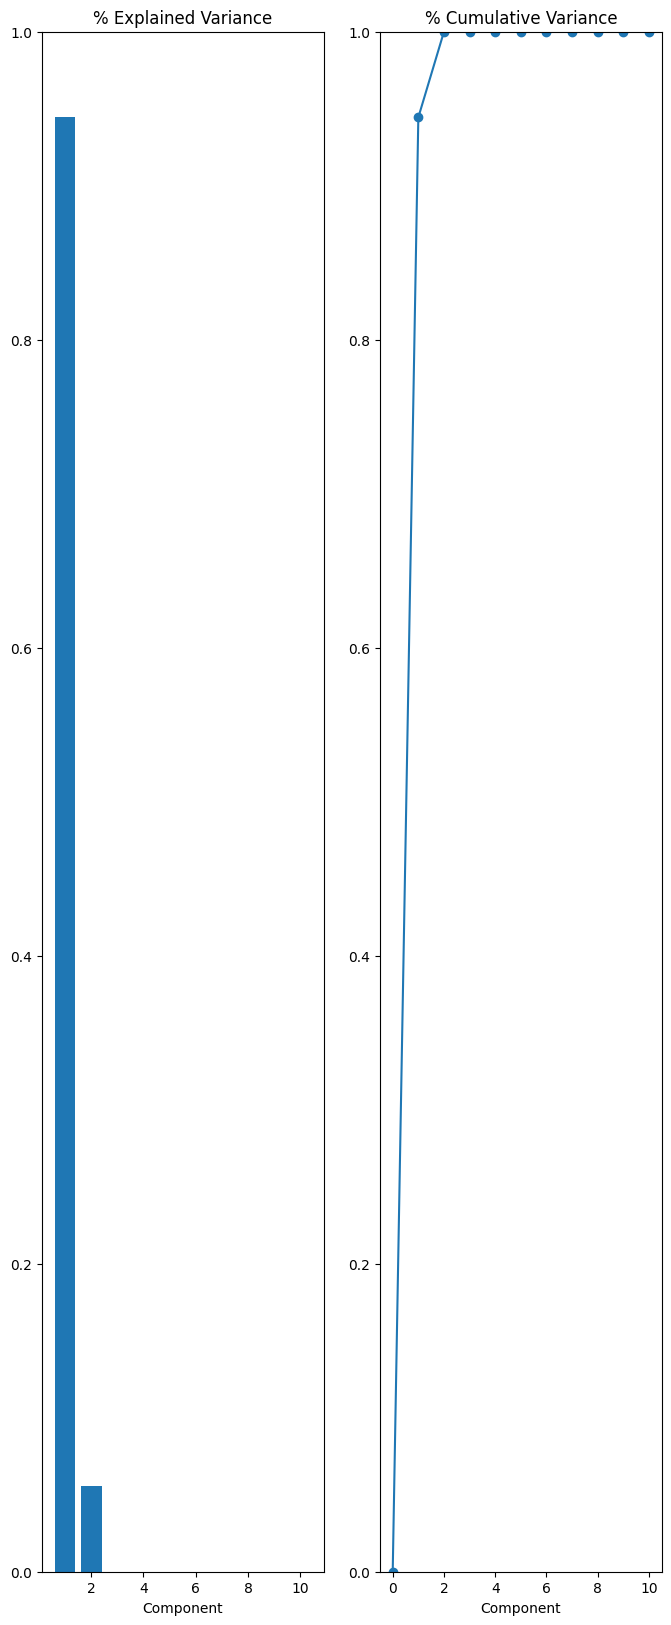

In [24]:
# Perform Principal Component Analysis to 
# learn a meaningful subspace to train ML algorithms on
Prince = PCA(n_components = 10).fit(Standardized_X_train)
plot_variance(Prince)

In [25]:
# Create a DataFrame for the Principal Components
PCA_Components = pd.DataFrame(Prince.components_, columns = X_train_cla.columns)

In [ ]:
# Display the Principal Components
PCA_Components

In [29]:
# Perform PCA decomposition to identify which features make up a certain PC.
abs(PCA_Components.iloc[2])/(np.sum(PCA_Components.iloc[2].values))

log_moid         0.00
H                0.00
log_q            0.00
log_e            0.00
Log_Diameter     0.05
moid             0.00
e                0.00
log_n            0.00
q                0.00
n                0.00
i                0.00
rms              0.00
diameter         0.62
diameter_sigma   1.59
a                0.00
albedo           0.05
tp               0.00
ad               0.00
per              0.02
per_y            0.02
tp_cal           0.00
om               0.00
sigma_om         0.00
Name: 2, dtype: float64

In [26]:
# Transform the Original Space into the learned Subspace
Standardized_X_pca = pd.DataFrame(Prince.transform(Standardized_X_train), columns = ["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9", "pca_10"])
Standardized_X_valid_pca = pd.DataFrame(Prince.transform(Standardized_X_valid), columns =  ["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9", "pca_10"])

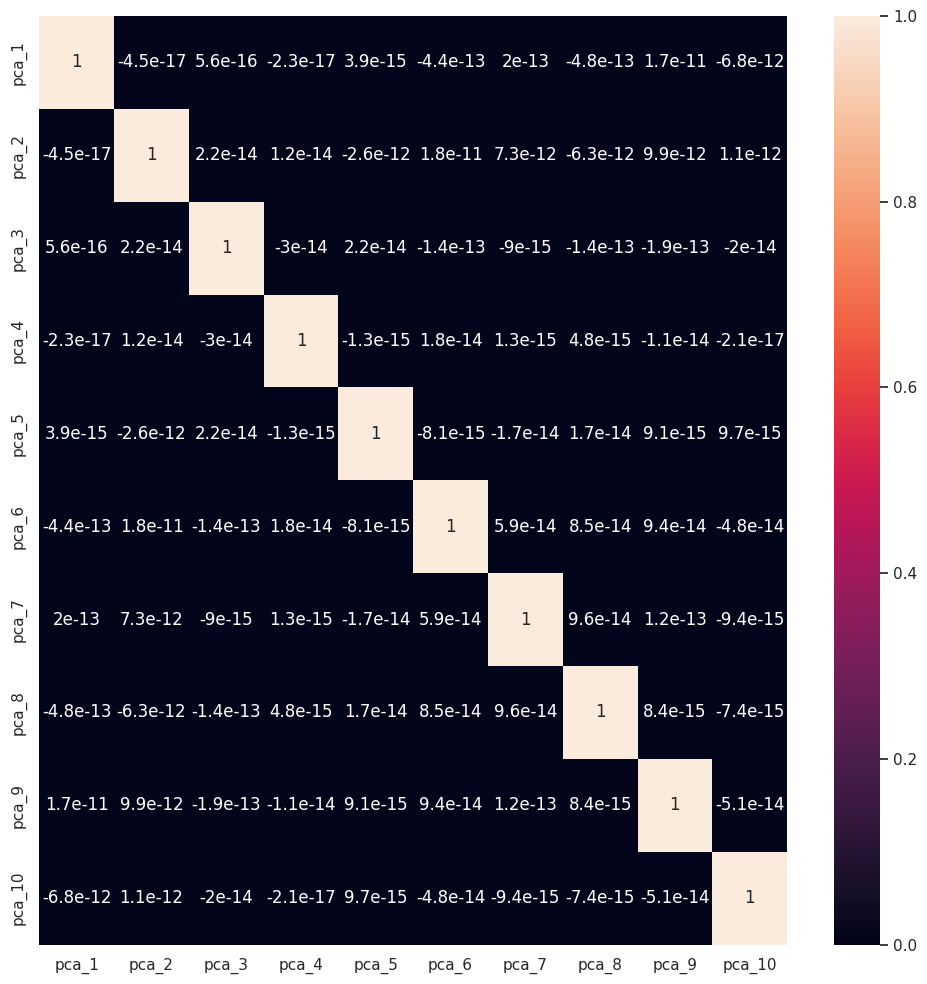

In [186]:
# Ensure that the PCA analysis has as intended removed the multicollinarity of the features
Correlation_Matrix = Standardized_X_pca.corr()
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(data = Correlation_Matrix, annot = True)
plt.tight_layout()

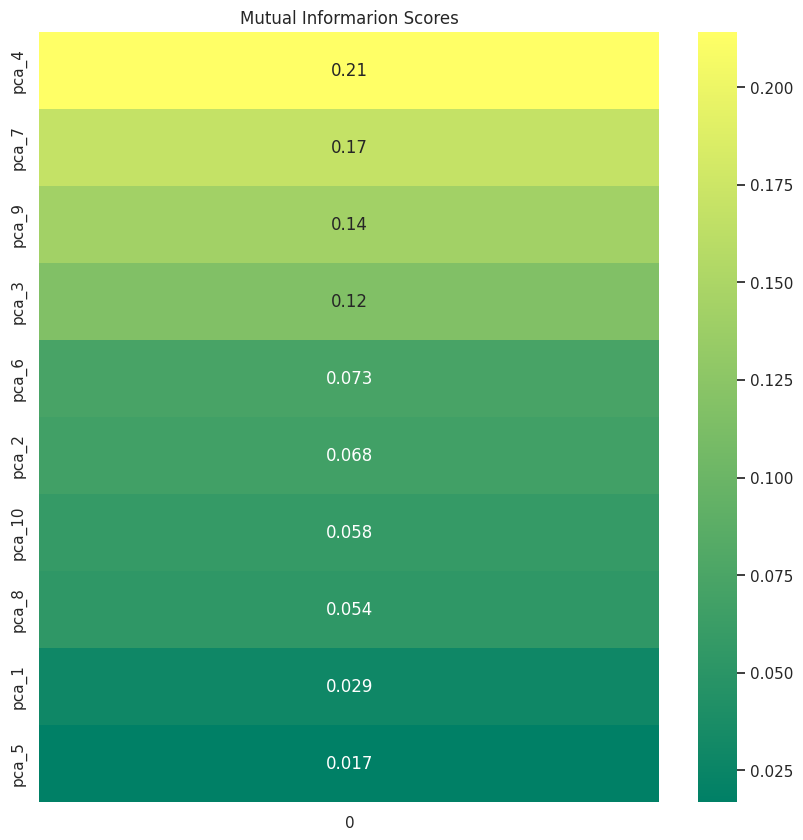

In [187]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Classification
mutual_information_cla = make_mi_scores(Standardized_X_pca, y_train_cla["MBA"], categoric_values = "auto")
plot_mi_scores(mutual_information_cla, cmap = "summer")

<Axes: >

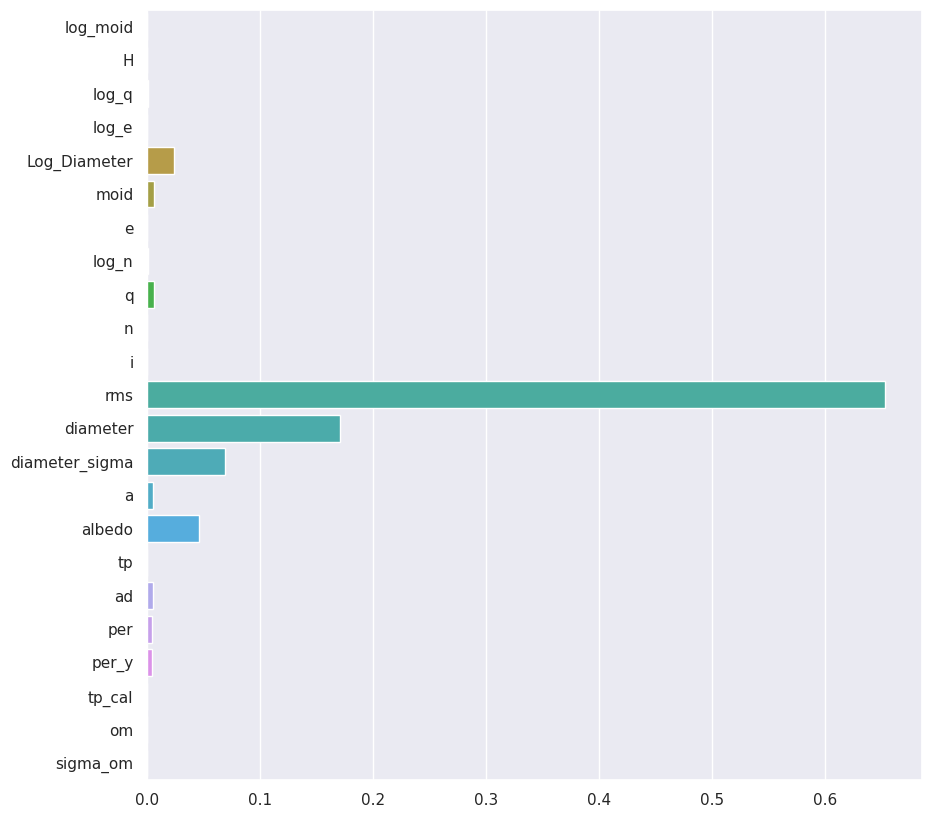

In [188]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 4
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

<Axes: >

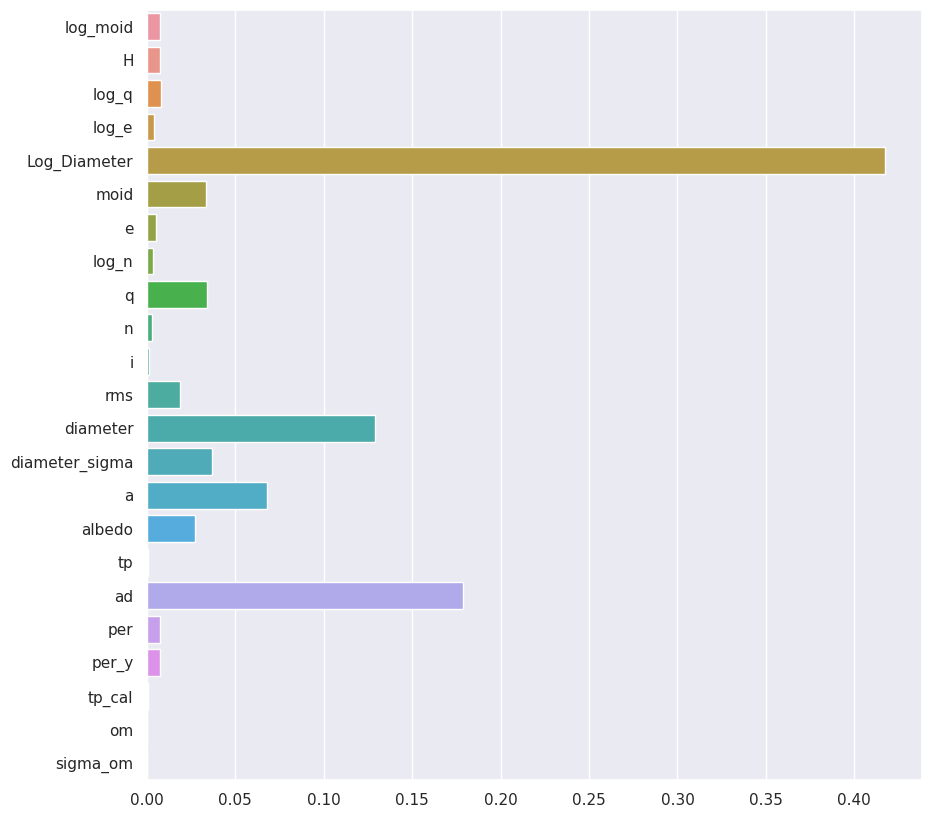

In [189]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 7
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

<Axes: >

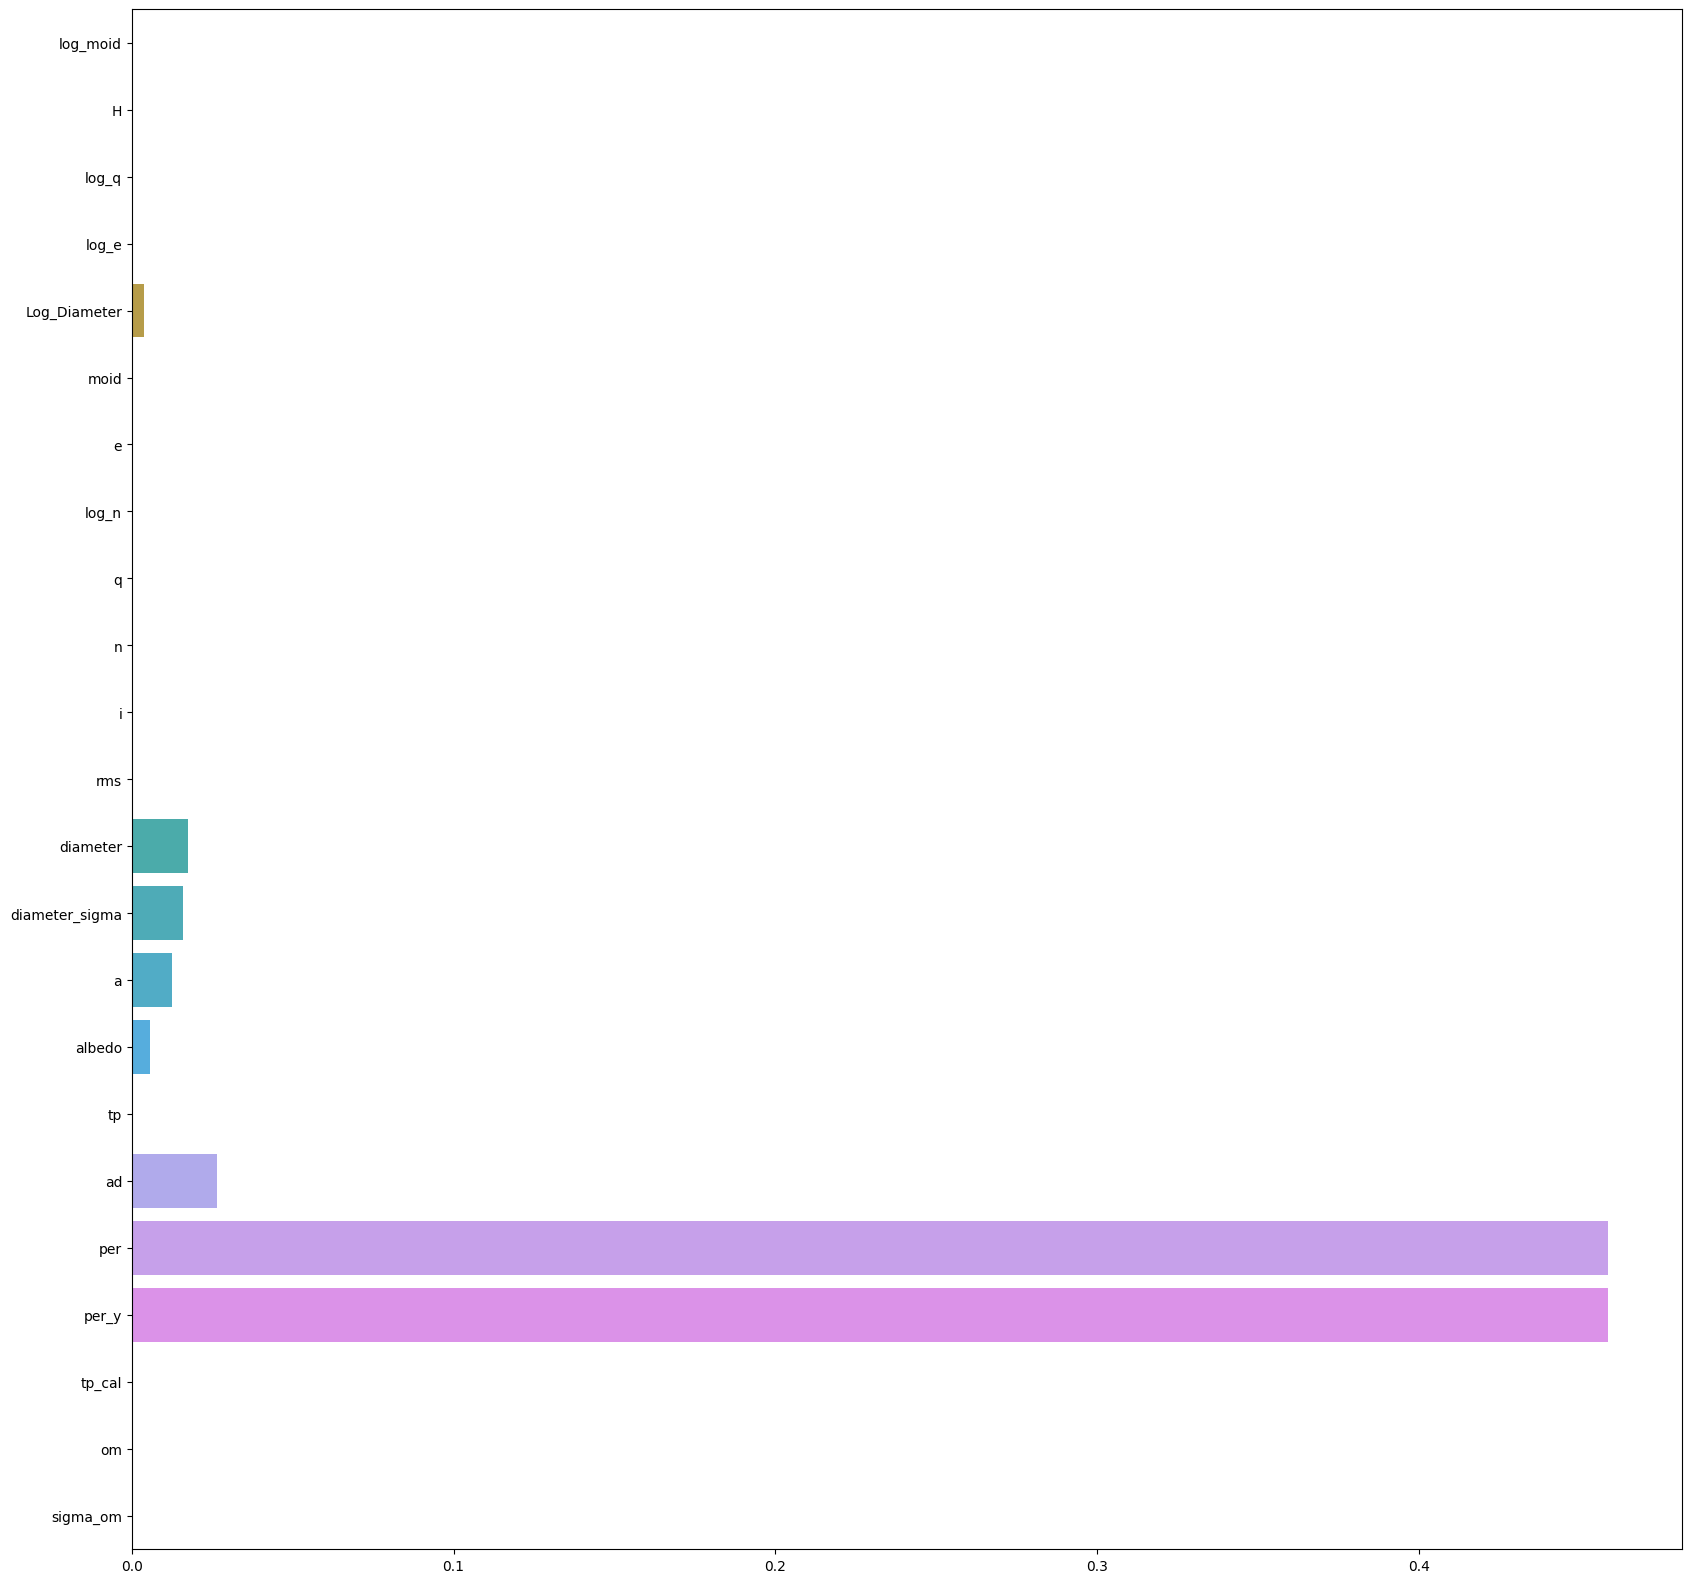

In [80]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 3
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

<Axes: >

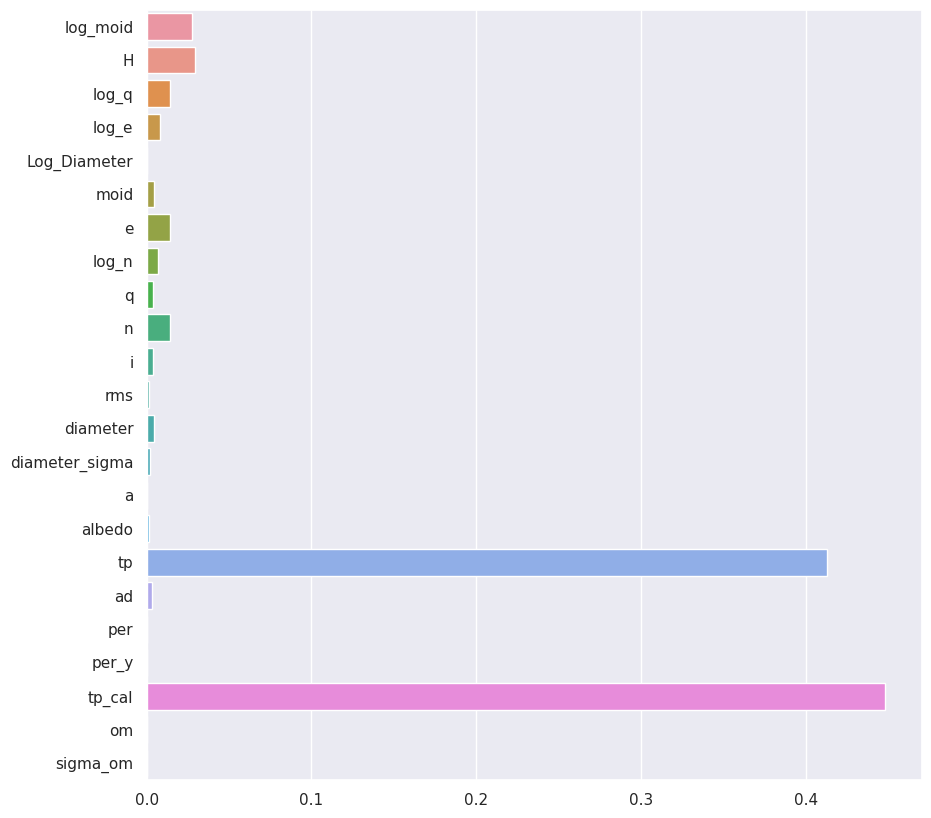

In [190]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 9
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

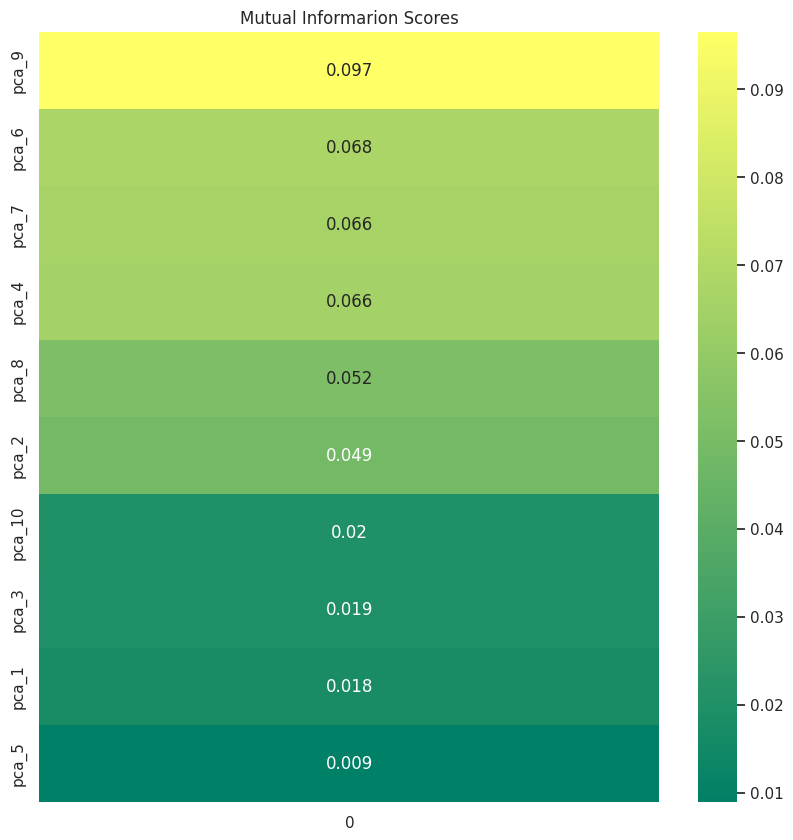

In [193]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Classification
mutual_information_cla = make_mi_scores(Standardized_X_pca, y_train_cla["neo"], categoric_values = "auto")
plot_mi_scores(mutual_information_cla, cmap = "summer")

<Axes: >

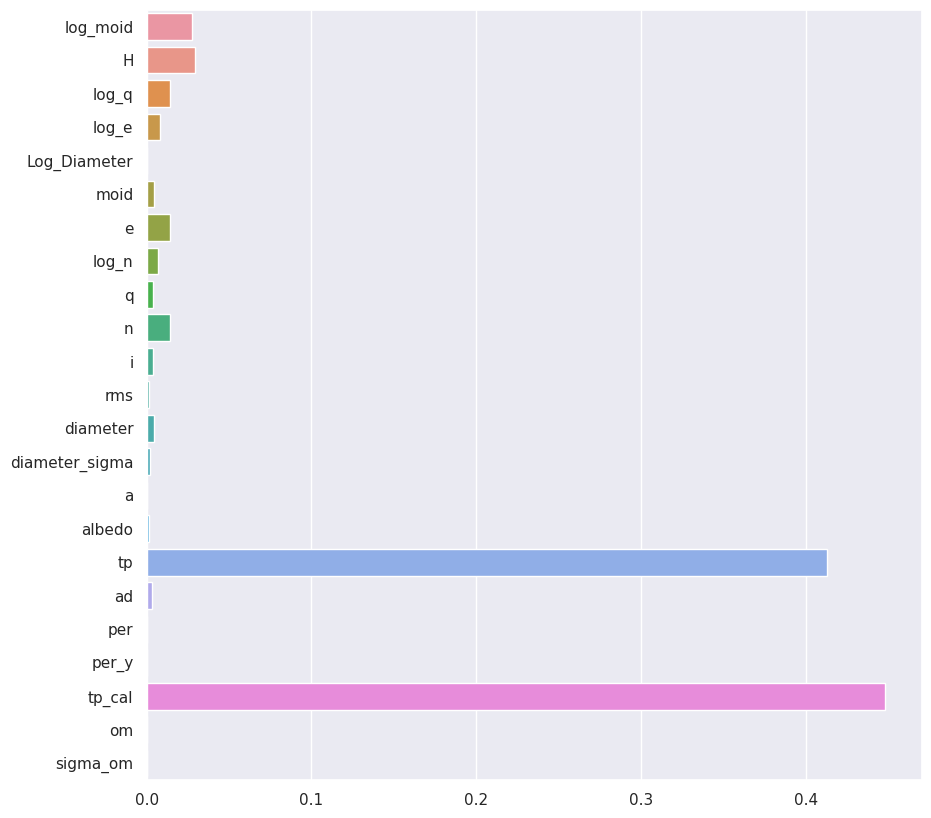

In [194]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 9
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

<Axes: >

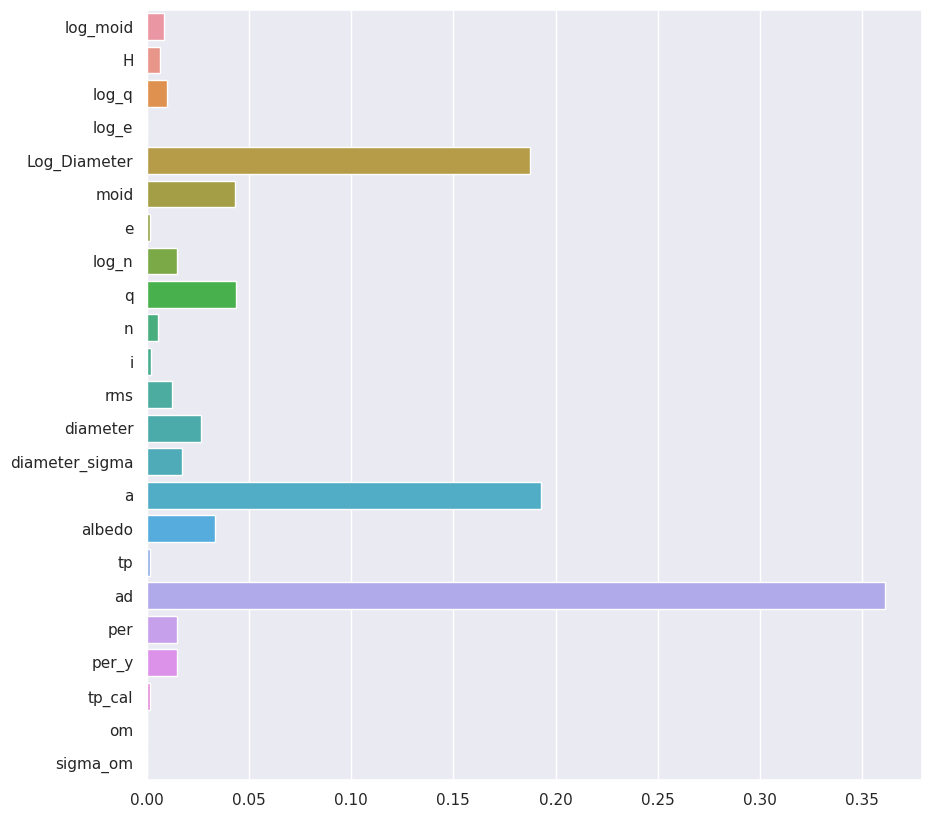

In [195]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 6
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

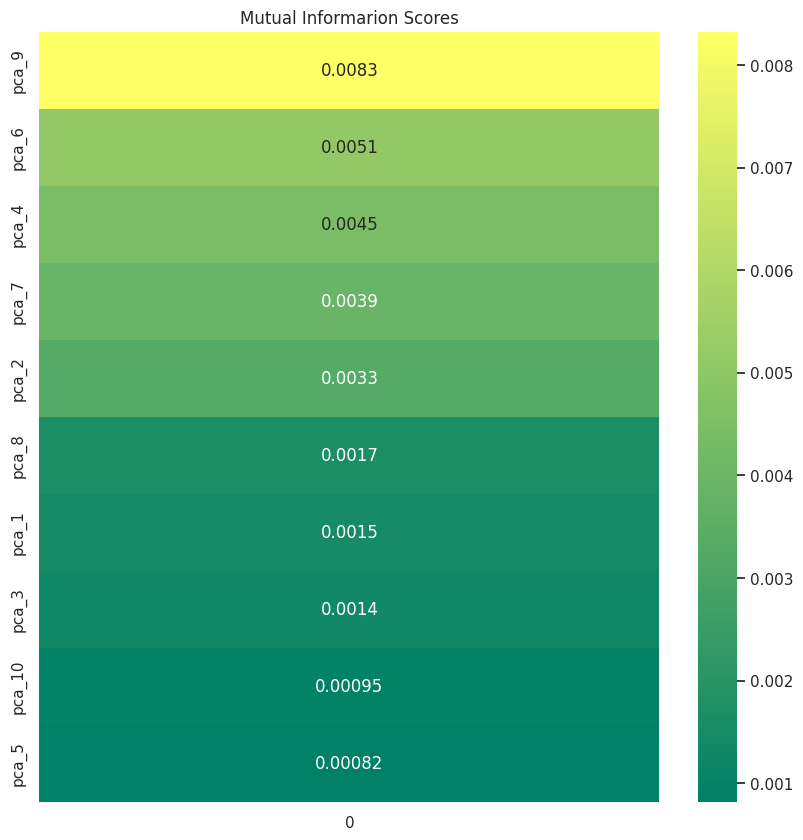

In [192]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Classification
mutual_information_cla = make_mi_scores(Standardized_X_pca, y_train_cla["pha"], categoric_values = "auto")
plot_mi_scores(mutual_information_cla, cmap = "summer")

<Axes: >

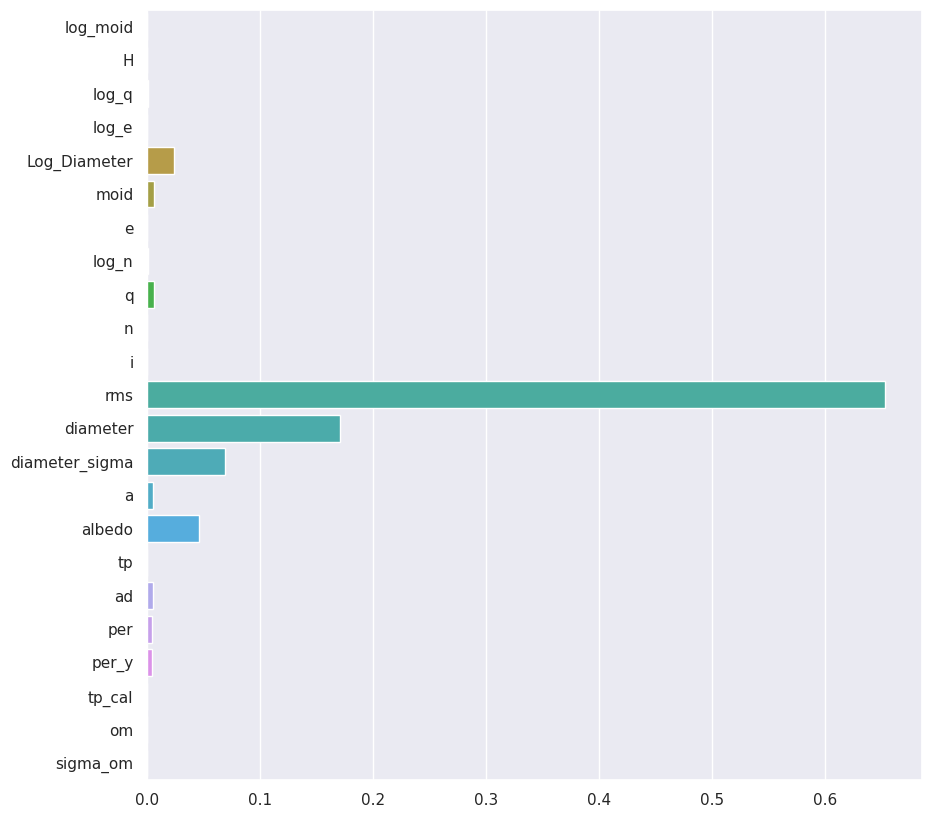

In [196]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 4
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

In [198]:
# Repeating the above, though now with the Principal Components, 
# use LazyClassifier to scan for the best base ML algorithms for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_pca.iloc[:20000], Standardized_X_valid_pca.iloc[:20000], y_train_cla.iloc[:20000,0], y_valid_cla.iloc[:20000,0])
models

100%|██████████| 29/29 [01:38<00:00,  3.41s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,1.00,0.99,0.99,1.00,0.57
RandomForestClassifier,1.00,0.99,0.99,1.00,7.96
LGBMClassifier,1.00,0.99,0.99,1.00,1.27
BaggingClassifier,1.00,0.99,0.99,1.00,1.82
ExtraTreesClassifier,1.00,0.98,0.98,1.00,2.07
DecisionTreeClassifier,0.99,0.98,0.98,0.99,0.35
AdaBoostClassifier,0.99,0.96,0.96,0.99,2.34
ExtraTreeClassifier,0.98,0.96,0.96,0.98,0.09
KNeighborsClassifier,0.97,0.87,0.87,0.97,3.27


In [200]:
# Repeating the above, though now with the Principal Components, 
# use LazyClassifier to scan for the best base ML algorithms for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_pca.iloc[:20000], Standardized_X_valid_pca.iloc[:20000], y_train_cla.iloc[:20000,1], y_valid_cla.iloc[:20000,1])
models

100%|██████████| 29/29 [01:21<00:00,  2.80s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,1.00,0.97,0.97,1.00,0.54
LGBMClassifier,1.00,0.97,0.97,1.00,1.68
BaggingClassifier,1.00,0.96,0.96,1.00,1.40
RandomForestClassifier,1.00,0.96,0.96,1.00,4.84
AdaBoostClassifier,1.00,0.96,0.96,1.00,2.34
DecisionTreeClassifier,1.00,0.96,0.96,1.00,0.26
ExtraTreesClassifier,1.00,0.93,0.93,1.00,1.73
ExtraTreeClassifier,0.99,0.87,0.87,0.99,0.08
QuadraticDiscriminantAnalysis,0.69,0.83,0.83,0.79,0.25


In [199]:
# Repeating the above, though now with the Principal Components, 
# use LazyClassifier to scan for the best base ML algorithms for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_pca.iloc[:20000], Standardized_X_valid_pca.iloc[:20000], y_train_cla.iloc[:20000,2], y_valid_cla.iloc[:20000,2])
models

100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,1.00,1.00,1.00,1.00,1.21
XGBClassifier,1.00,1.00,1.00,1.00,0.47
RandomForestClassifier,1.00,1.00,1.00,1.00,6.41
ExtraTreesClassifier,1.00,1.00,1.00,1.00,1.69
BaggingClassifier,1.00,0.99,0.99,1.00,1.45
AdaBoostClassifier,1.00,0.99,0.99,1.00,2.46
DecisionTreeClassifier,1.00,0.99,0.99,1.00,0.28
ExtraTreeClassifier,0.99,0.98,0.98,0.99,0.08
KNeighborsClassifier,0.99,0.96,0.96,0.99,2.94


In [202]:
# Repeating the above, though now with the Principal Components, 
# use LazyClassifier to scan for the best base ML algorithms for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_pca.iloc[:20000], Standardized_X_valid_pca.iloc[:20000], y_train_cla.iloc[:20000,3], y_valid_cla.iloc[:20000,3])
models

100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.17
AdaBoostClassifier,1.00,0.99,0.99,1.00,2.59
XGBClassifier,1.00,0.99,0.99,1.00,0.42
LGBMClassifier,1.00,0.99,0.99,1.00,0.97
ExtraTreesClassifier,1.00,0.99,0.99,1.00,1.72
LinearSVC,1.00,0.99,0.99,1.00,0.21
RandomForestClassifier,1.00,0.99,0.99,1.00,4.09
BaggingClassifier,1.00,0.99,0.99,1.00,0.79
KNeighborsClassifier,1.00,0.99,0.99,1.00,3.11


In [203]:
# Repeating the above, though now with the Principal Components, 
# use LazyClassifier to scan for the best base ML algorithms for the task
clr = LazyClassifier(ignore_warnings = True, custom_metric = None)
models, predictions  = clr.fit(Standardized_X_pca.iloc[:20000], Standardized_X_valid_pca.iloc[:20000], y_train_cla.iloc[:20000,4], y_valid_cla.iloc[:20000,4])
models

100%|██████████| 29/29 [01:04<00:00,  2.21s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.97,0.98,0.98,0.98,0.08
QuadraticDiscriminantAnalysis,0.98,0.94,0.94,0.99,0.26
PassiveAggressiveClassifier,1.00,0.83,0.83,1.00,0.19
LinearDiscriminantAnalysis,0.99,0.76,0.76,0.99,0.27
AdaBoostClassifier,1.00,0.75,0.75,1.00,2.34
LGBMClassifier,1.00,0.71,0.71,1.00,1.09
DecisionTreeClassifier,1.00,0.71,0.71,1.00,0.16
XGBClassifier,1.00,0.69,0.69,1.00,0.41
BaggingClassifier,1.00,0.68,0.68,1.00,0.67


In [216]:
# Print the PCA dataframe to perform visual testing
Standardized_X_pca

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,-31911.05,-1121.06,-24.06,-3.26,-0.63,0.19,-0.86,0.72,-0.40,0.90
1,-31910.44,-1131.91,-22.34,-2.74,1.46,1.82,-0.01,1.12,-0.23,-0.11
2,-31909.66,-1130.84,-23.32,-3.38,-0.60,2.40,-1.06,0.73,0.46,-1.60
3,-31909.78,-1131.40,-22.73,-3.50,0.33,1.37,-1.13,0.65,-0.44,-0.10
4,-31911.14,-1127.83,-28.79,-4.67,-0.52,2.65,-2.42,-0.20,-1.28,-0.19
...,...,...,...,...,...,...,...,...,...,...
600771,-31910.66,-1128.92,-24.94,-3.29,-0.64,0.71,0.30,-1.27,-1.72,-1.58
600772,-31907.02,-1131.01,-23.08,-3.38,0.27,0.97,-0.66,0.28,-1.03,0.25
600773,-31832.15,-1131.70,-23.16,-4.06,0.99,1.23,-2.05,0.58,-0.59,-0.94
600774,-31911.16,-1130.31,-23.14,-3.17,-1.15,0.96,-0.18,-0.14,-0.73,1.02


In [27]:
# Fit A standard RandomForestClassifier with balanced class weights to classify the targets
Rf_Model = RandomForestClassifier(class_weight = "balanced").fit(Standardized_X_pca, y_train_cla)
print(Rf_Model.score(Standardized_X_pca, y_train_cla))
print(Rf_Model.score(Standardized_X_valid_pca, y_valid_cla))
print(precision_score(y_valid_cla, Rf_Model.predict(Standardized_X_valid_pca), average = "weighted"))

1.0
0.9964312822083439
0.9976079688958498


In [28]:
# Generate Test Dataset
Test_Dataset_Cla = Generator_Classification(Test_Dataset)
Test_Dataset_Cla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187629 entries, 0 to 187628
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           187629 non-null  float64
 1   H               187629 non-null  float64
 2   diameter        187629 non-null  float64
 3   albedo          187629 non-null  float64
 4   diameter_sigma  187629 non-null  float64
 5   epoch           187629 non-null  float64
 6   epoch_mjd       187629 non-null  float64
 7   epoch_cal       187629 non-null  float64
 8   e               187629 non-null  float64
 9   a               187629 non-null  float64
 10  q               187629 non-null  float64
 11  i               187629 non-null  float64
 12  om              187629 non-null  float64
 13  w               187629 non-null  float64
 14  ma              187629 non-null  float64
 15  ad              187629 non-null  float64
 16  n               187629 non-null  float64
 17  tp        

In [29]:
# To perform the classification split the dataset into training and validaiton sets
Test_X, Test_y = Test_Dataset_Cla[Selected_Features], Test_Dataset_Cla[Classification_Targets]
Standardized_X_test = (Test_X - Test_X.quantile(0.25))/(Test_X.quantile(0.75) - Test_X.quantile(0.25))
Standardized_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187629 entries, 0 to 187628
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   log_moid        187629 non-null  float64
 1   H               187629 non-null  float64
 2   log_q           187629 non-null  float64
 3   log_e           187629 non-null  float64
 4   Log_Diameter    187629 non-null  float64
 5   moid            187629 non-null  float64
 6   e               187629 non-null  float64
 7   log_n           187629 non-null  float64
 8   q               187629 non-null  float64
 9   n               187629 non-null  float64
 10  i               187629 non-null  float64
 11  rms             187629 non-null  float64
 12  diameter        187629 non-null  float64
 13  diameter_sigma  187629 non-null  float64
 14  a               187629 non-null  float64
 15  albedo          187629 non-null  float64
 16  tp              187629 non-null  float64
 17  ad        

In [30]:
# Transform the test feature space into the test subspace.
Standardized_X_Test_pca = pd.DataFrame(Prince.transform(Standardized_X_test), columns =  ["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9", "pca_10"])

In [31]:
# Print the evaluation scores.
print(Rf_Model.score(Standardized_X_Test_pca, Test_y))
print(precision_score(Test_y, Rf_Model.predict(Standardized_X_Test_pca), average = "weighted"))

0.9914885225631432
0.9931529663465992


In [32]:
# Generate the Predictions on the test set to estimate the generalisation error
Predictions = pd.DataFrame(Rf_Model.predict(Standardized_X_Test_pca), columns = Test_y.columns)

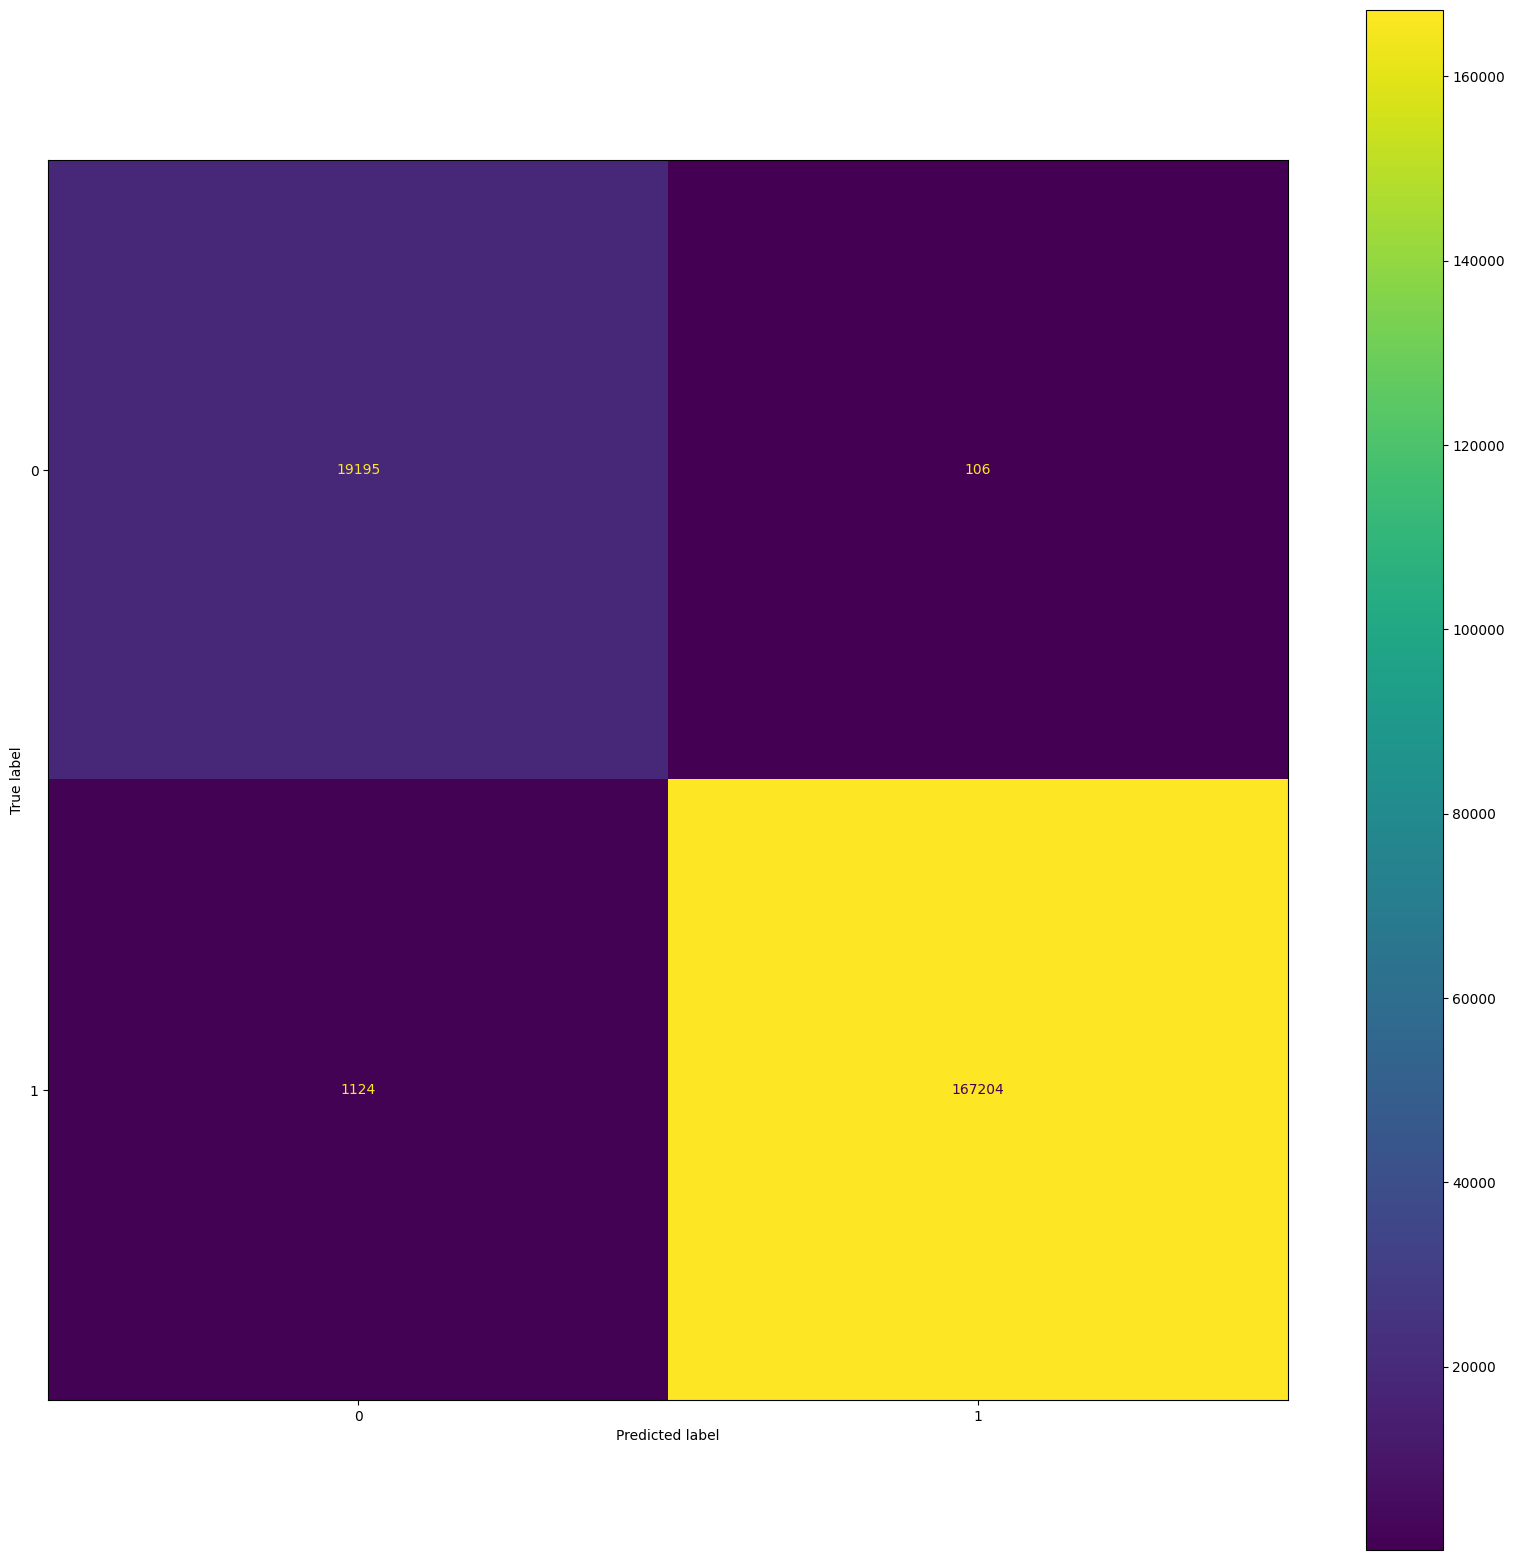

In [33]:
# Generate a Confusion Matrix to ensure that Classifier is able to identity both classes
confusion_mat = confusion_matrix(Predictions.iloc[:,0], Test_y.iloc[:,0])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

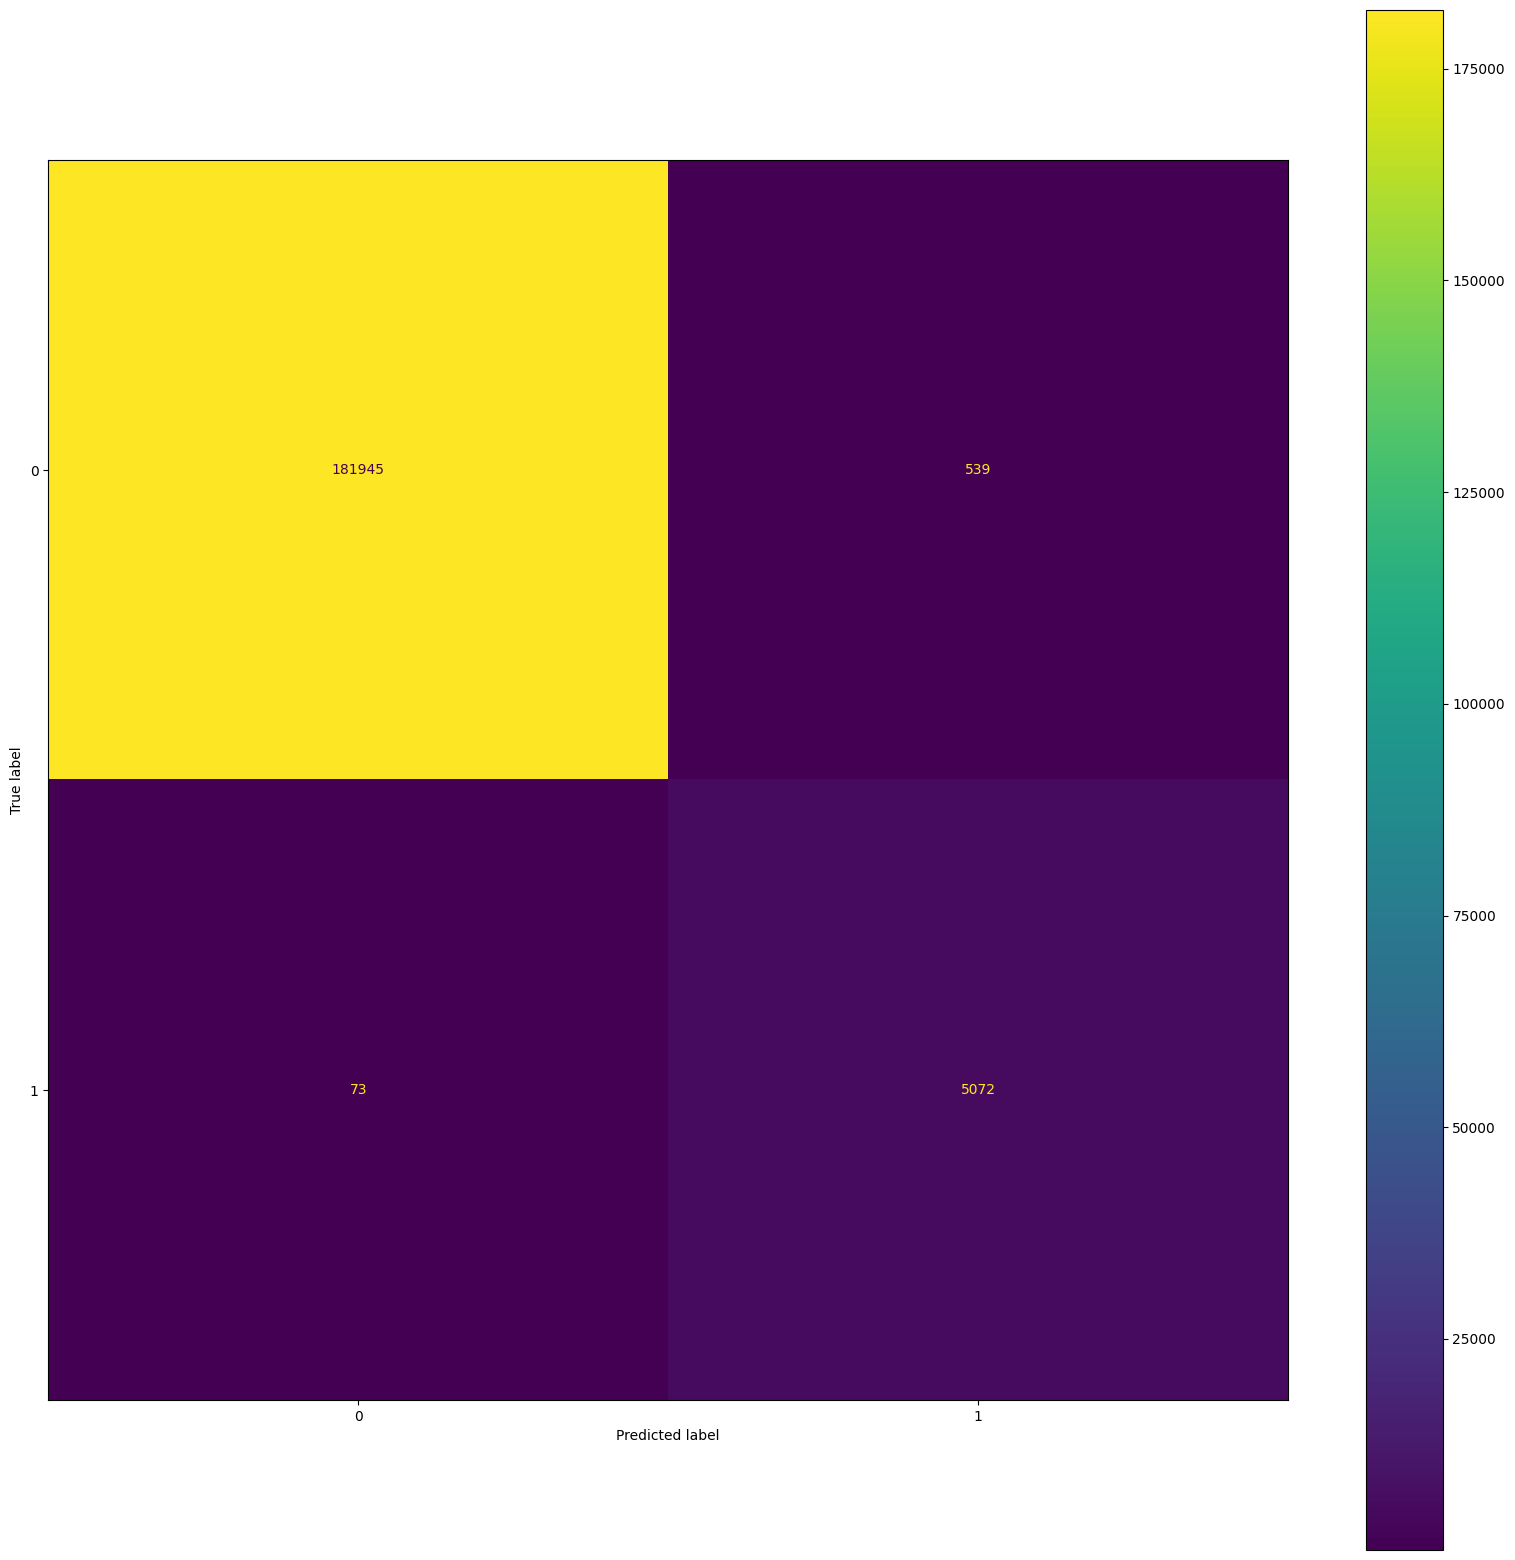

In [34]:
# Generate a Confusion Matrix to ensure that Classifier is able to identity both classes
confusion_mat = confusion_matrix(Predictions.iloc[:,1], Test_y.iloc[:,1])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

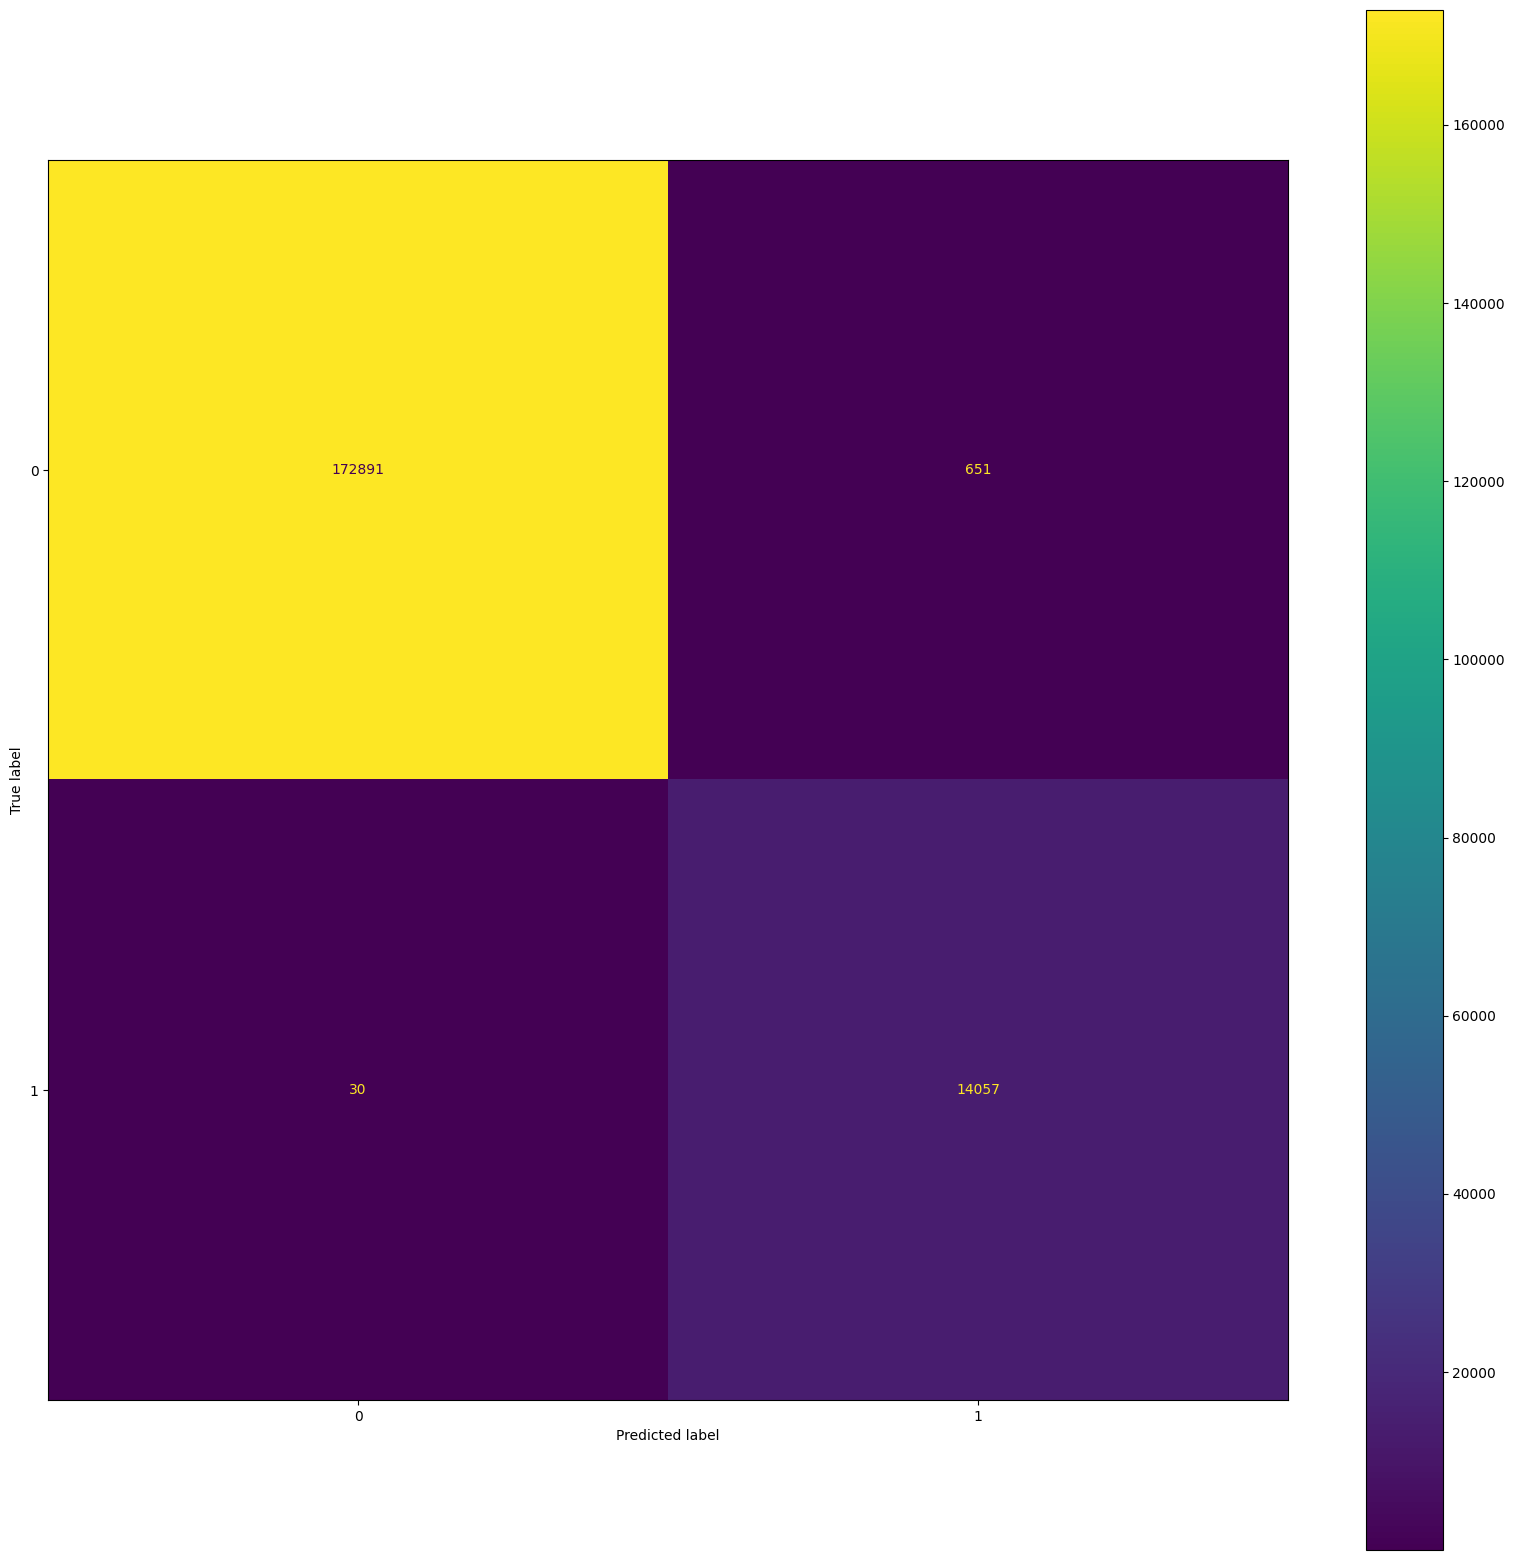

In [35]:
# Generate a Confusion Matrix to ensure that Classifier is able to identity both classes
confusion_mat = confusion_matrix(Predictions.iloc[:,2], Test_y.iloc[:,2])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

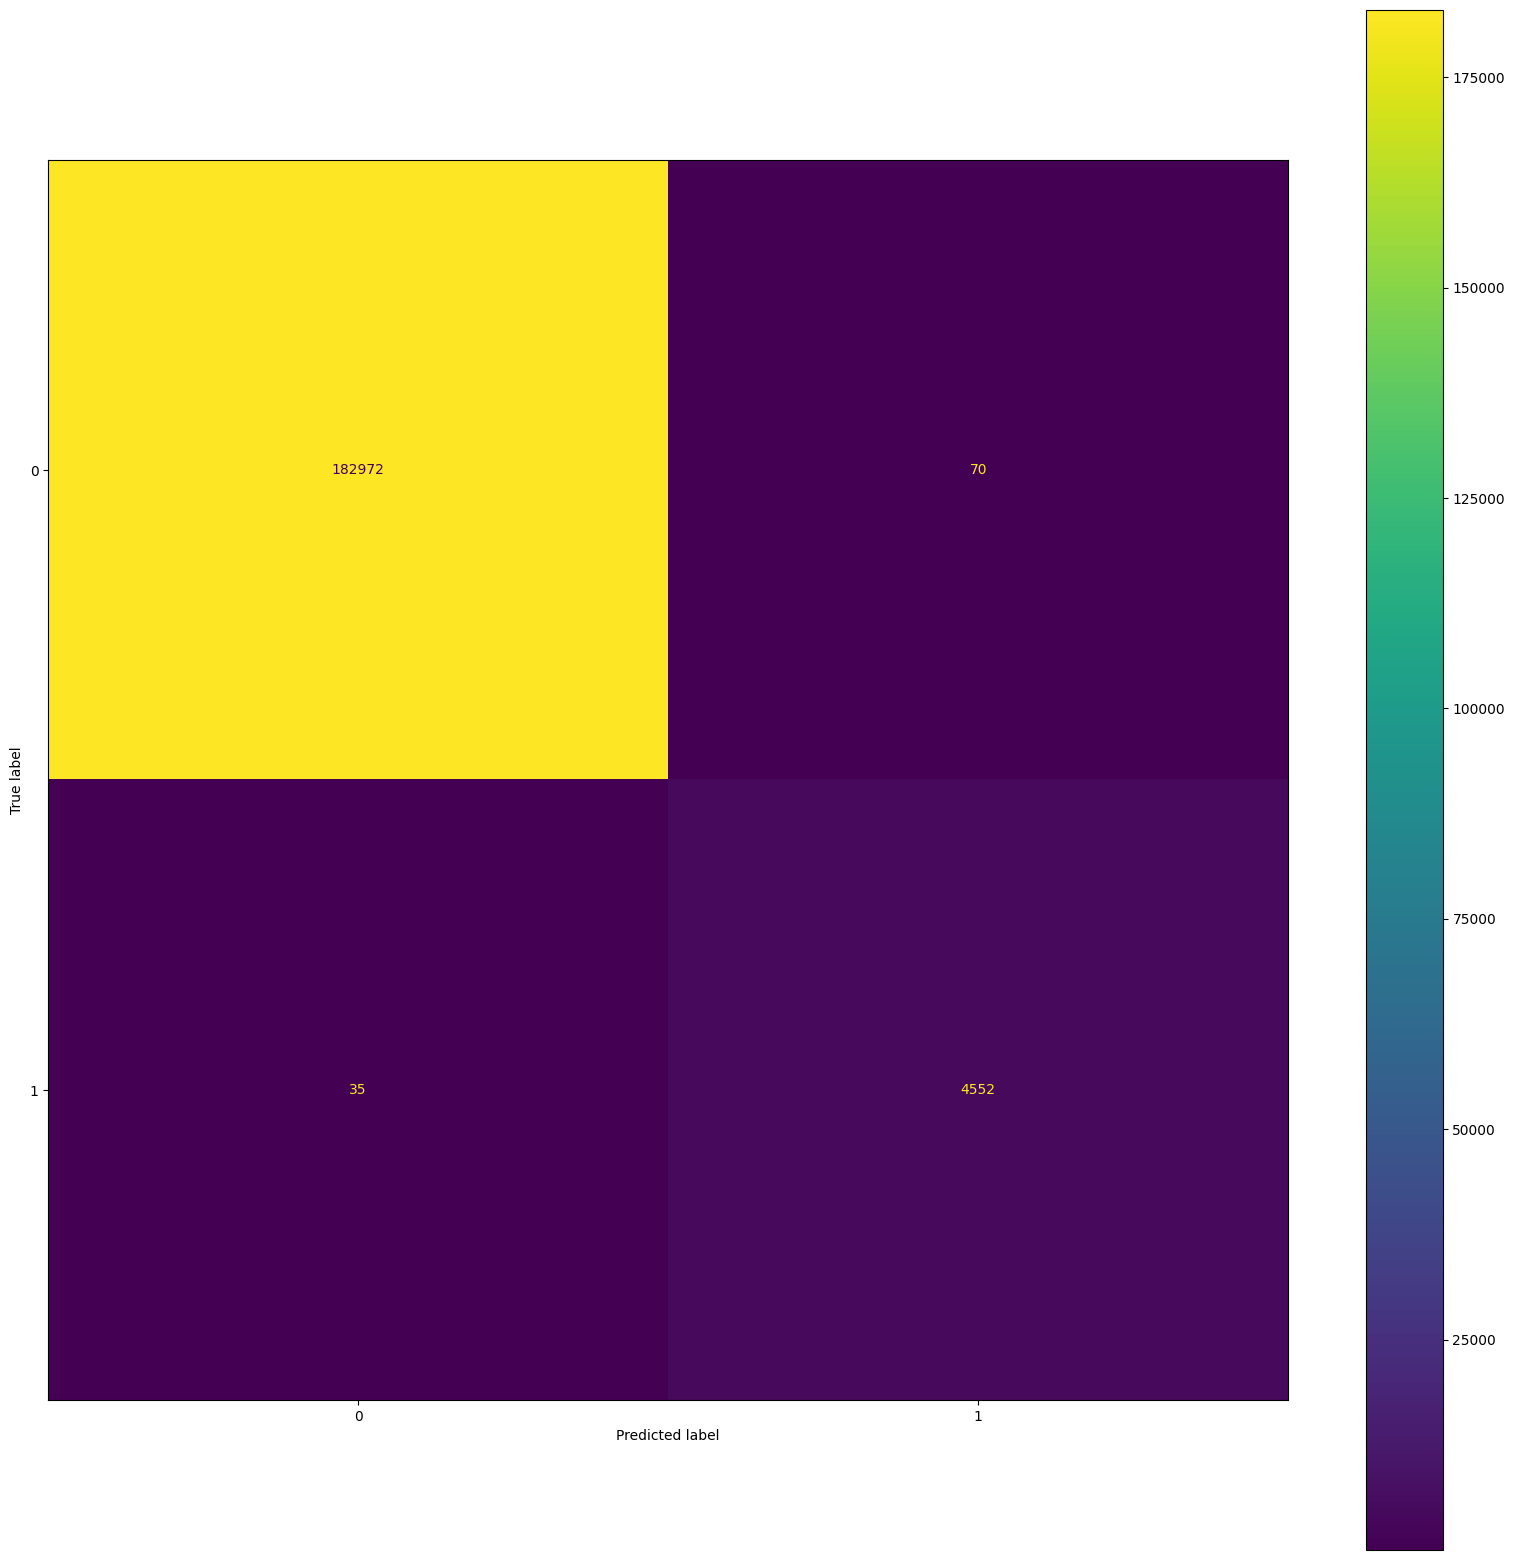

In [36]:
# Generate a Confusion Matrix to ensure that Classifier is able to identity both classes
confusion_mat = confusion_matrix(Predictions.iloc[:,3], Test_y.iloc[:,3])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

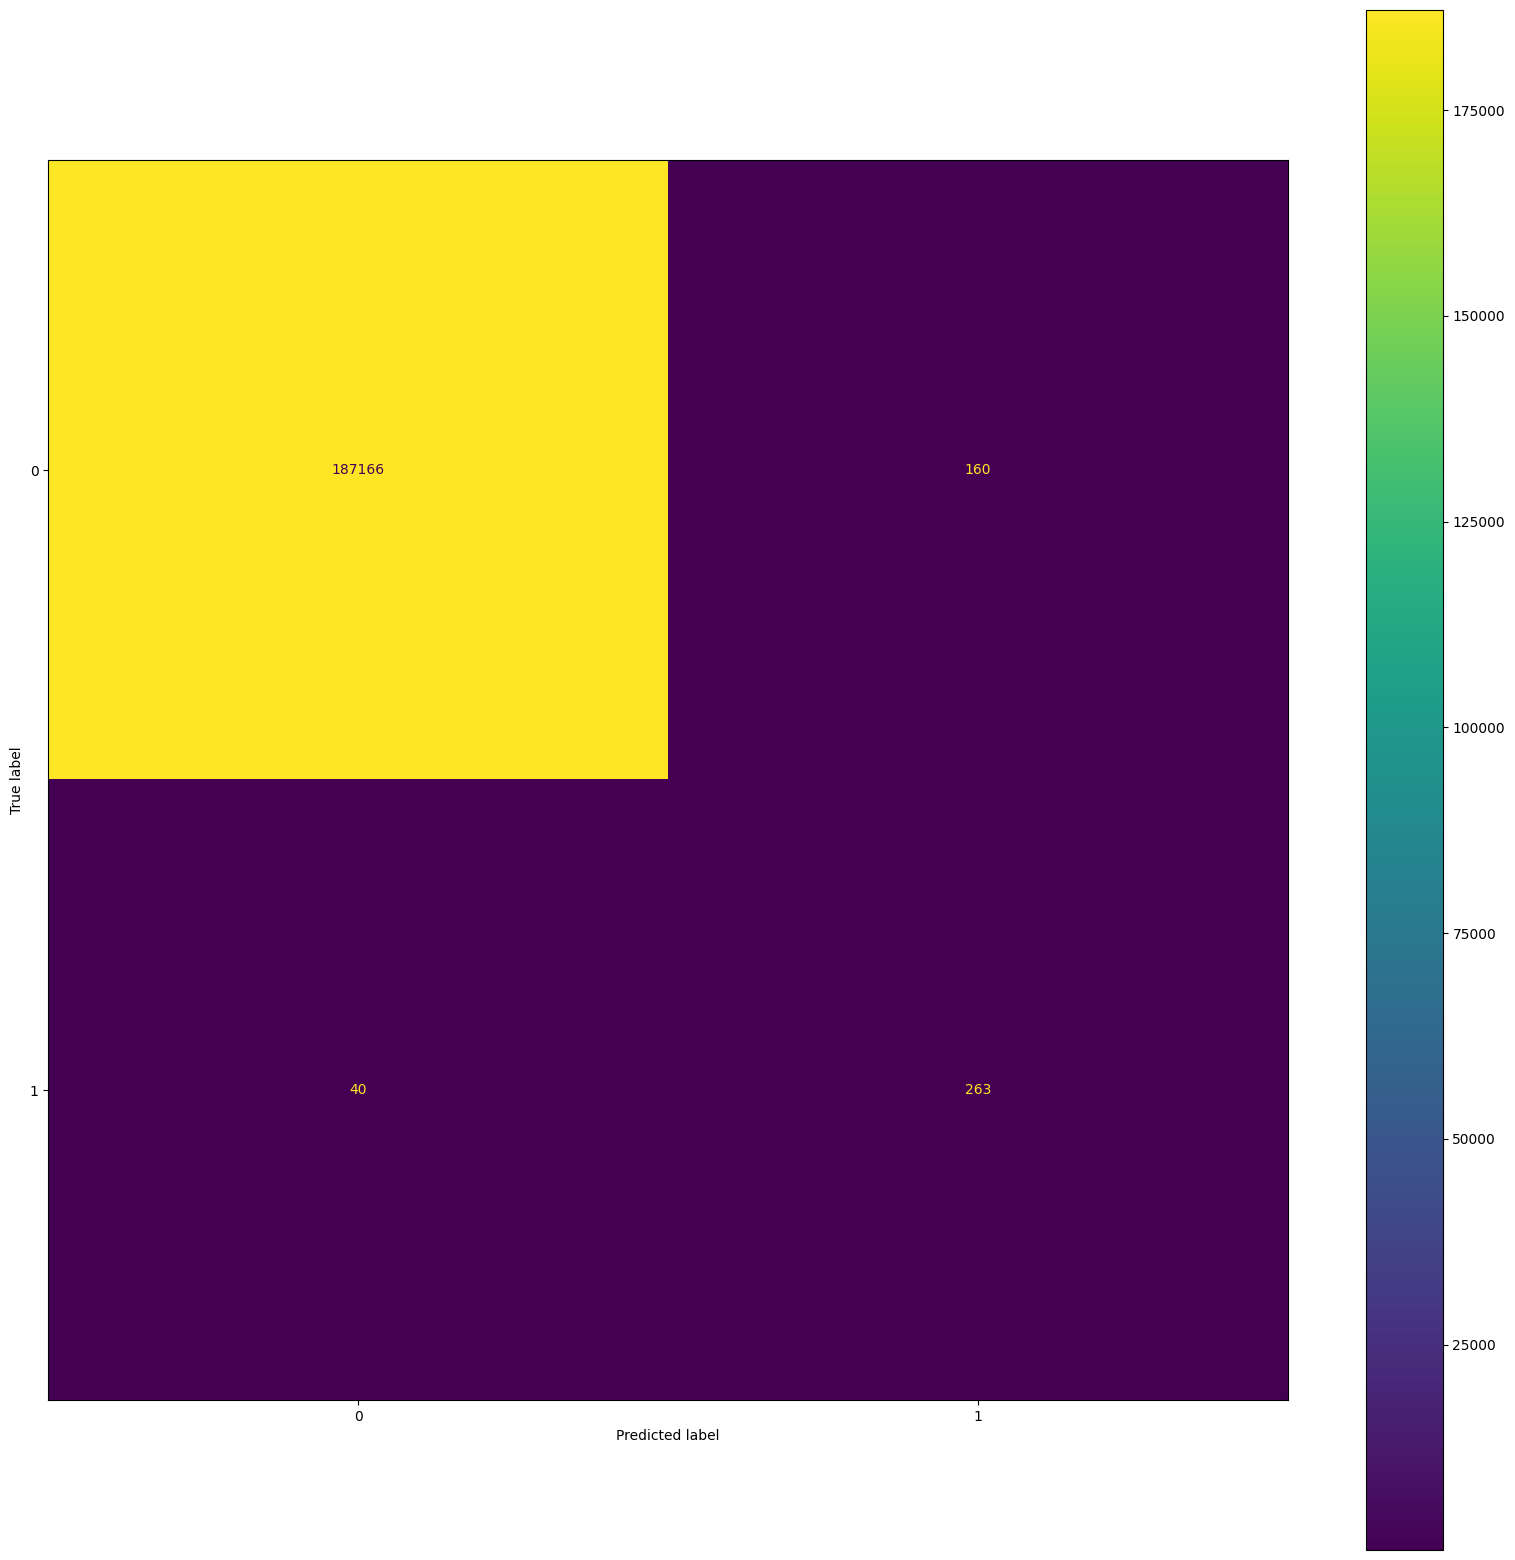

In [37]:
# Generate a Confusion Matrix to ensure that Classifier is able to identity both classes
confusion_mat = confusion_matrix(Predictions.iloc[:,4], Test_y.iloc[:,4])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [40]:
# Use the Shapley Library to generate an Explainer object to identify feature importance 
# and interactions between features.
Explainer = shap.Explainer(Rf_Model, Standardized_X_Test_pca.iloc[:10000])

In [41]:
# Generate the Shapley values for 10000 data-points
Shapley_Values = Explainer(Standardized_X_Test_pca.iloc[:10000], check_additivity = False)

100%|===================| 99958/100000 [33:26<00:00]        

In [44]:
# Determine the shape of the resulting Shap-value matrix
Shapley_Values.values.shape

(10000, 10, 10)

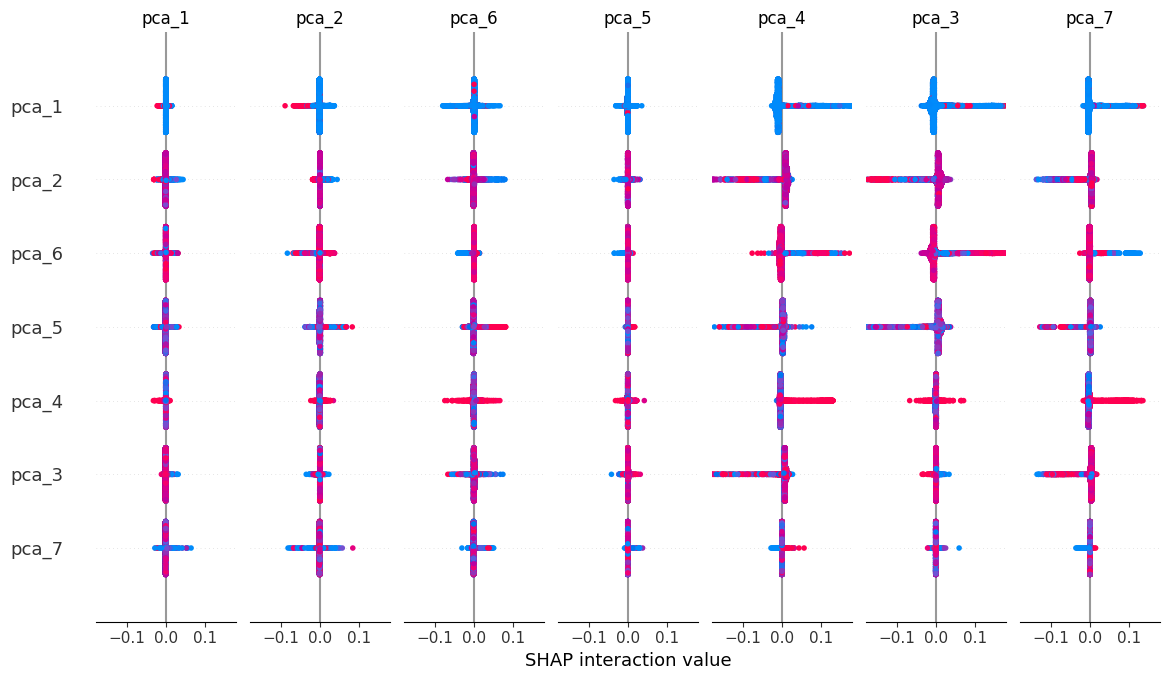

In [66]:
# Print a summary plot showing the interactions between 
# different PCA components to make predictions
shap.summary_plot(Shapley_Values[:, :, :].values,Standardized_X_Test_pca.iloc[:10000])

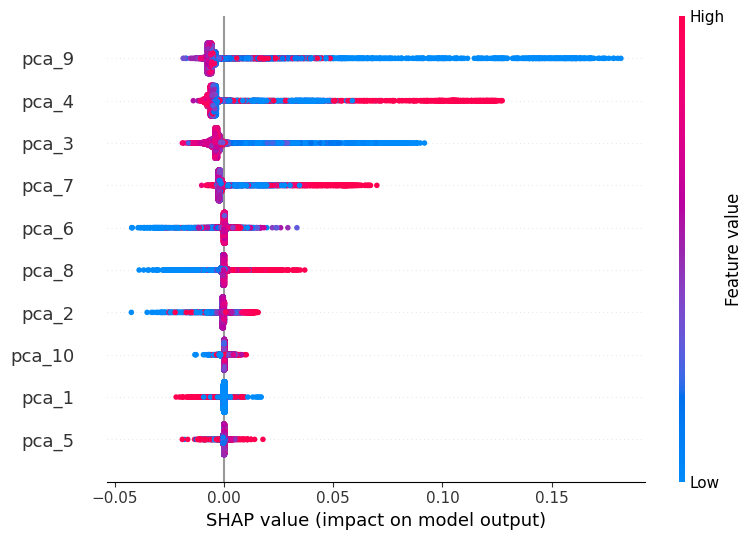

In [75]:
# Print an individual Summary Plot to closer analyse the influence of 
# individual PCs on the predictions a model makes.
shap.summary_plot(Shapley_Values[:, :, 0].values,Standardized_X_Test_pca.iloc[:10000])

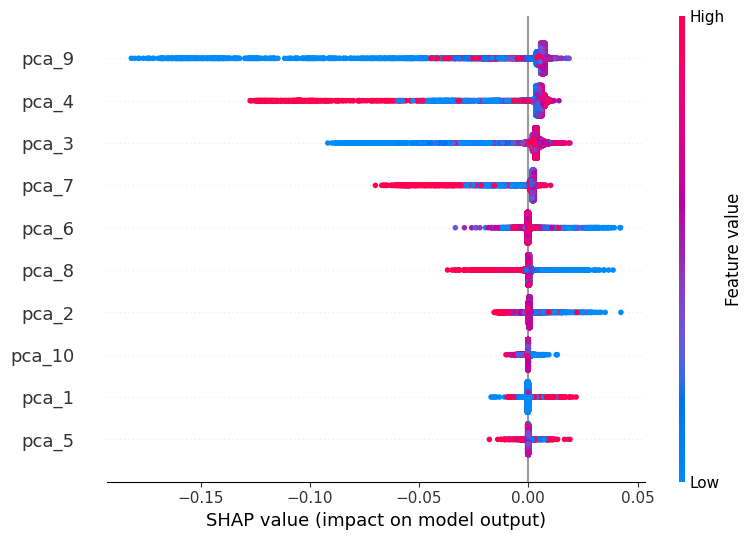

In [76]:
# Print an individual Summary Plot to closer analyse the influence of 
# individual PCs on the predictions a model makes.
shap.summary_plot(Shapley_Values[:, :, 1].values,Standardized_X_Test_pca.iloc[:10000])

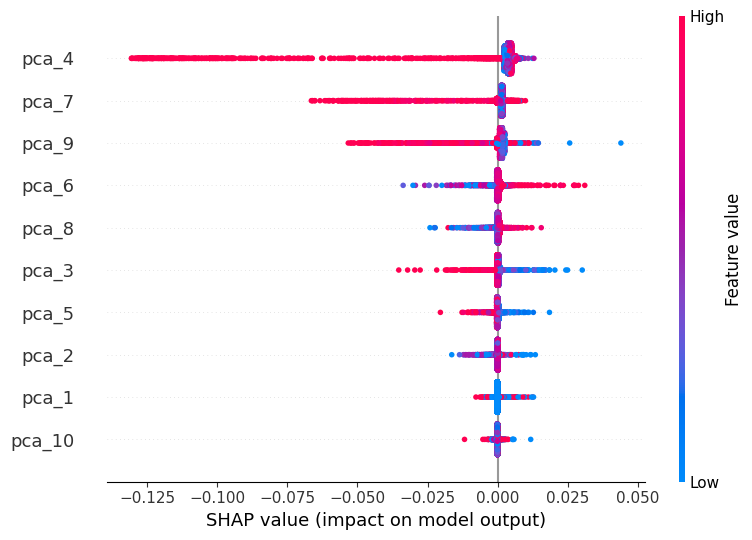

In [77]:
# Print an individual Summary Plot to closer analyse the influence of 
# individual PCs on the predictions a model makes.
shap.summary_plot(Shapley_Values[:, :, 2].values,Standardized_X_Test_pca.iloc[:10000])

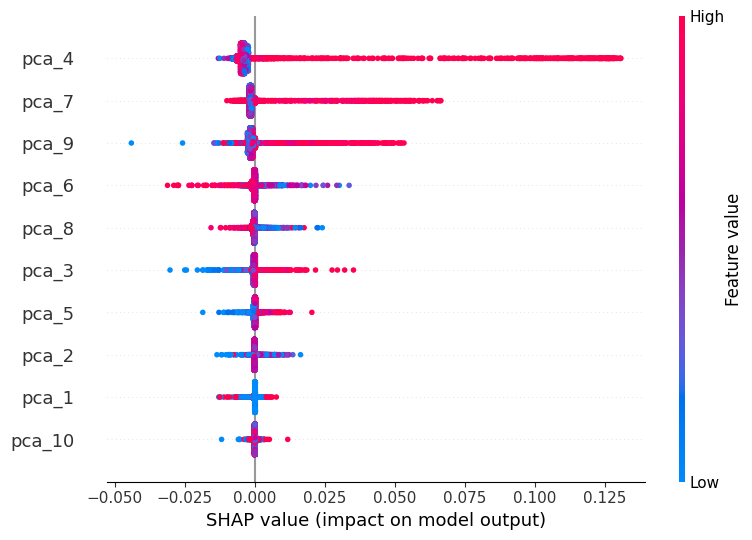

In [78]:
# Print an individual Summary Plot to closer analyse the influence of 
# individual PCs on the predictions a model makes.
shap.summary_plot(Shapley_Values[:, :, 3].values,Standardized_X_Test_pca.iloc[:10000])

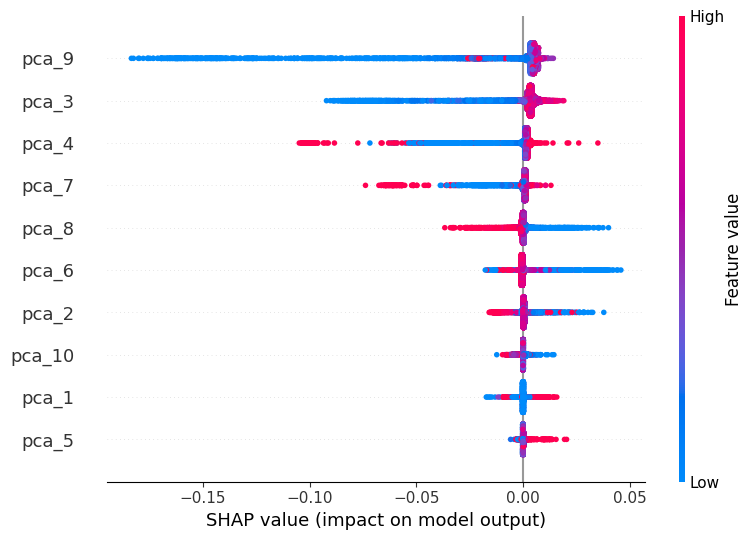

In [79]:
# Print an individual Summary Plot to closer analyse the influence of 
# individual PCs on the predictions a model makes.
shap.summary_plot(Shapley_Values[:, :, 4].values,Standardized_X_Test_pca.iloc[:10000])

In [67]:
shapley_values = Explainer.shap_values(Standardized_X_Test_pca.iloc[:10000], Test_y.iloc[:10000], check_additivity = False)

100%|===================| 99958/100000 [32:24<00:00]        

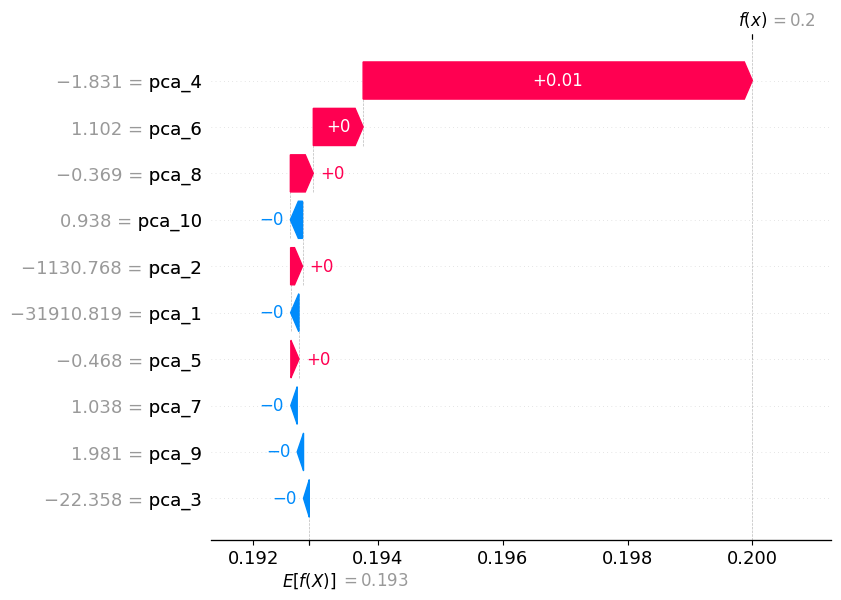

In [74]:
# Print an individual Waterfall Plot to closer analyse the influence of 
# individual PCs on an individual prediction made by the model.
shap.plots.waterfall(Shapley_Values[100,:,2])

# Conclusion
In this Juypter Notebook to high accuracy and Precision, we have classifield whether an Asteroid is potentially harzardess or not, whether it is near earth object or not, and what type of asteroid it was. The LazyPredict Classifier was used to determine which ML algorithm would act as the base of the analysis for both the original feature space as input and the learned subspace of features. From this analysis it was chosen that a RandomForestClassifier with the PCs as features would be the best model to base the analysis on considering both time to train and final accuracy and precision scores. This algorithm was trained on the train set and then evaluated on the test set to generate a final generalisation score. Shapley values were then used to determine the feature importance of the PCs components and to show interactions between features. From this analysis the 4th, 7th 3rd and 9th PC components play the largest role in the model's prediction. PC decomposition shows that these PC components correspond to the diamater and it's uncertainity, the albedo, semi-major axis and time of passing the perhelion.